<a href="https://colab.research.google.com/github/Marrmotta/dissertation/blob/Experiment-1B/Experiment_1B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 1B

## Data Import and Preprocessing

In [38]:
# Install necessary libraries
!pip install gspread google-auth google-auth-oauthlib google-auth-httplib2

# Import libraries
import gspread
from google.auth.transport.requests import Request
from google.oauth2.service_account import Credentials

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import mixedlm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc

from statsmodels.stats.multicomp import MultiComparison

In [ ]:
# Upload credentials file
from google.colab import files
uploaded = files.upload()  # Select the 'credentials.json' file

In [2]:
# Check the uploaded file name
credentials_filename = list(uploaded.keys())[0]

# Define the scopes
SCOPE = [
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive'
]

# Load credentials from the uploaded file
creds = Credentials.from_service_account_file(credentials_filename, scopes=SCOPE)

# Authorize and create the client
gc = gspread.authorize(creds)

In [3]:
# Create helper functions
# Define the function to calculate Hedge's g
def hedges_g(mean1, mean2, sd1, sd2, n1, n2):
    pooled_sd = np.sqrt(((n1 - 1) * sd1 ** 2 + (n2 - 1) * sd2 ** 2) / (n1 + n2 - 2))
    g = (mean1 - mean2) / pooled_sd
    correction_factor = 1 - (3 / (4 * (n1 + n2) - 9))
    hedges_g_value = g * correction_factor
    return hedges_g_value

# Define the function to categorize recall responses
def categorize_recall_response(response):
    if response == -99:
        return 'Blank'
    elif response == 0:
        return 'Incorrect'
    elif response == 1:
        return 'Partially Correct'
    elif response == 2:
        return 'Correct'
    elif response == 3:
        return 'Intrusion'
    else:
        return None

# Define the function to categorize target information mentions
def categorize_target_info(response):
    if response == -99:
        return 'Blank'
    elif response == 0:
        return 'No Target Mentioned'
    elif response == 1:
        return 'Accurate Frame Mentioned'
    elif response == 2:
        return 'Misinformed Frame Mentioned'
    else:
        return None

# Function to process participant data
def process_participant_data(participant_row, counterbalance_df, gk_items):
    result = {
        'Total Blank': 0,
        'Total Incorrect': 0,
        'Total Partially Correct': 0,
        'Total Correct': 0,
        'Total Intrusion': 0,
        'Accurate Blank': 0,
        'Accurate Incorrect': 0,
        'Accurate Partially Correct': 0,
        'Accurate Correct': 0,
        'Accurate Intrusion': 0,
        'Neutral Blank': 0,
        'Neutral Incorrect': 0,
        'Neutral Partially Correct': 0,
        'Neutral Correct': 0,
        'Neutral Intrusion': 0,
        'Misleading Blank': 0,
        'Misleading Incorrect': 0,
        'Misleading Partially Correct': 0,
        'Misleading Correct': 0,
        'Misleading Intrusion': 0,
        'Easy Blank': 0,
        'Easy Incorrect': 0,
        'Easy Partially Correct': 0,
        'Easy Correct': 0,
        'Easy Intrusion': 0,
        'Hard Blank': 0,
        'Hard Incorrect': 0,
        'Hard Partially Correct': 0,
        'Hard Correct': 0,
        'Hard Intrusion': 0,
        'Total No Target Mentioned': 0,
        'Total Accurate Frame Mentioned': 0,
        'Total Misinformed Frame Mentioned': 0
    }

    for gk_num in gk_items:
        row = counterbalance_df[counterbalance_df['GK'] == gk_num].iloc[0]
        difficulty = row['Difficulty']
        experiment = 'E1'
        version = participant_row['Version']
        version_map = {'A': 'A', 'B': 'B', 'C': 'C'}
        frame_col = f'{experiment}{version_map[version]}'
        frame = row[frame_col]
        response_col = f'GK{gk_num}_coded'
        response = participant_row[response_col]

        category = categorize_recall_response(response)
        if category is None:
            continue

        result[f'Total {category}'] += 1

        if frame == 1:
            frame_type = 'Accurate'
        elif frame == 2:
            frame_type = 'Neutral'
        elif frame == 3:
            frame_type = 'Misleading'
        else:
            continue

        result[f'{frame_type} {category}'] += 1

        if difficulty == 0:
            result[f'Easy {category}'] += 1
        elif difficulty == 1:
            result[f'Hard {category}'] += 1

        # Process target information mentions
        target_response_col = f'GK{gk_num}_coded_target'
        target_response = participant_row[target_response_col]

        target_category = categorize_target_info(target_response)
        if target_category is None:
            continue

        result[f'Total {target_category.replace(" ", "_")}'] += 1

    return result

# Create a function to get the fact framing based on the version and item
def get_fact_framing(version, item):
    version_column = f'E1{version}'
    item_number = int(item.split('_')[0][2:])
    if version_column in counterbalance_data and item_number in counterbalance_data['GK']:
        item_index = counterbalance_data['GK'].index(item_number)
        framing_code = counterbalance_data[version_column][item_index]
        return 'Accurate' if framing_code == 1 else ('Neutral' if framing_code == 2 else 'Misleading')
    return 'Unknown'


In [4]:
# Load & Process Exp 1A Data
# Open the Google Sheet by name
spreadsheet_name = 'Dissertation Data R to Py'
sheet_name = 'Experiment 1B GK Only'
sheet = gc.open(spreadsheet_name).worksheet(sheet_name)

# Get the data as a list of lists
data = sheet.get_all_values()

# Convert data to DataFrame
gk_data_exp_1B = pd.DataFrame(data[1:], columns=data[0])
print("Data from Google Sheets:")
print(gk_data_exp_1B.head())

Data from Google Sheets:
  ID Progress Duration (in seconds) Presentation Version Total Recall Blank  \
0  1      100                   525            0       C                  9   
1  2      100                   848            0       A                 18   
2  3      100                  1468            1       B                  3   
3  4      100                  1378            1       A                 28   
4  5      100                  1238            0       B                 34   

  Total Incorrect Recall Total Partial Correct Recall Total Correct Recall  \
0                      5                           21                    0   
1                      4                           14                    0   
2                      4                           28                    1   
3                      4                            4                    0   
4                      0                            2                    0   

  Total Intrusion Recall  ... G

In [5]:
# Check the data types of the columns
print("Data types before conversion:")
print(gk_data_exp_1B.dtypes)

# Convert columns to appropriate types if necessary
for column in gk_data_exp_1B.columns:
    if '_coded' in column or 'Duration' in column or 'Total' in column:
        gk_data_exp_1B[column] = pd.to_numeric(gk_data_exp_1B[column], errors='coerce').fillna(-99).astype(int)

# Verifying types after conversion
print("Data types after conversion:")
print(gk_data_exp_1B.dtypes)


Data types before conversion:
ID                       object
Progress                 object
Duration (in seconds)    object
Presentation             object
Version                  object
                          ...  
GK32_coded_target        object
GK33_coded_target        object
GK34_coded_target        object
GK35_coded_target        object
GK36_coded_target        object
Length: 86, dtype: object
Data types after conversion:
ID                       object
Progress                 object
Duration (in seconds)     int64
Presentation             object
Version                  object
                          ...  
GK32_coded_target         int64
GK33_coded_target         int64
GK34_coded_target         int64
GK35_coded_target         int64
GK36_coded_target         int64
Length: 86, dtype: object


In [6]:
# Set the counterbalancing guide
counterbalance_data = {
    'GK': list(range(1, 61)),  # GK items 1 to 60
    'Difficulty': [0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
    'E1A': [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],
    'E1B': [3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],
    'E1C': [2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],
}

# Ensure the columns include the individual item responses and target mentions
gk_item_columns = [f'GK{i}_coded' for i in range(1, 37)]
gk_target_columns = [f'GK{i}_coded_target' for i in range(1, 37)]
relevant_columns = ['ID', 'Progress', 'Duration (in seconds)', 'Presentation', 'Version'] + gk_item_columns + gk_target_columns

# Select relevant columns
filtered_df = gk_data_exp_1B[relevant_columns]

# Convert relevant columns to appropriate types
filtered_df.loc[:, 'Presentation'] = filtered_df['Presentation'].astype(int)  # Convert to integer first

# Map the presentation types
presentation_mapping = {0: 'Scrolling Feed', 1: 'Page-based'}
filtered_df.loc[:, 'Presentation'] = filtered_df['Presentation'].map(presentation_mapping)
filtered_df.loc[:, 'Presentation'] = filtered_df['Presentation'].astype('category')  # Then convert to category

filtered_df.loc[:, 'Version'] = filtered_df['Version'].astype('category')

# Rename & Ensure Duration (in seconds) is numeric
filtered_df.rename(columns={'Duration (in seconds)': 'Duration_sec'}, inplace=True)

filtered_df.loc[:, 'Duration_sec'] = pd.to_numeric(filtered_df['Duration_sec'], errors='coerce')

# Convert wide DataFrame to long format for recall responses
long_df_recall = pd.melt(filtered_df, id_vars=['ID', 'Presentation', 'Version', 'Duration_sec'],
                         value_vars=gk_item_columns,
                         var_name='Item', value_name='Response')

# Convert wide DataFrame to long format for target mentions
long_df_target = pd.melt(filtered_df, id_vars=['ID', 'Presentation', 'Version', 'Duration_sec'],
                         value_vars=gk_target_columns,
                         var_name='Item', value_name='Target_Response')

# Add the difficulty and fact framing information based on the item number and version
gk_items_difficulty = {f'GK{i}_coded': 'Easy' if difficulty == 0 else 'Hard' for i, difficulty in enumerate(counterbalance_data['Difficulty'], 1)}
gk_items_difficulty_target = {f'GK{i}_coded_target': 'Easy' if difficulty == 0 else 'Hard' for i, difficulty in enumerate(counterbalance_data['Difficulty'], 1)}

# Ensure 'Difficulty' is added correctly to both DataFrames
long_df_recall['Difficulty'] = long_df_recall['Item'].map(gk_items_difficulty)
long_df_target['Difficulty'] = long_df_target['Item'].map(gk_items_difficulty_target)

# Create a function to get the fact framing based on the version and item
def get_fact_framing(version, item):
    version_column = f'E1{version}'
    item_number = int(item.split('_')[0][2:])
    if version_column in counterbalance_data and item_number in counterbalance_data['GK']:
        item_index = counterbalance_data['GK'].index(item_number)
        framing_code = counterbalance_data[version_column][item_index]
        return 'Accurate' if framing_code == 1 else ('Neutral' if framing_code == 2 else 'Misleading')
    return 'Unknown'

# Ensure 'Fact_Framing' is added correctly to both DataFrames
long_df_recall['Fact_Framing'] = long_df_recall.apply(lambda row: get_fact_framing(row['Version'], row['Item']), axis=1)
long_df_target['Fact_Framing'] = long_df_target.apply(lambda row: get_fact_framing(row['Version'], row['Item']), axis=1)

# Ensure Response and Target_Response are numeric
long_df_recall['Response'] = long_df_recall['Response'].astype(int)
long_df_target['Target_Response'] = long_df_target['Target_Response'].astype(int)

# Add a new column for Decoded_Response for recall
response_mapping = {
    -99: 'Blank',
    0: 'Incorrect',
    1: 'Partially Correct',
    2: 'Correct',
    3: 'Intrusion'
}
long_df_recall['Decoded_Response'] = long_df_recall['Response'].map(response_mapping)

# Add a new column for Decoded_Target_Response for target mentions
target_response_mapping = {
    -99: 'Blank',
    0: 'No Target Mentioned',
    1: 'Accurate Frame Mentioned',
    2: 'Misinformed Frame Mentioned'
}
long_df_target['Decoded_Target_Response'] = long_df_target['Target_Response'].map(target_response_mapping)

# Ensure there are no hidden characters (e.g., leading/trailing spaces) in the merging keys
long_df_recall['ID'] = long_df_recall['ID'].str.strip()
long_df_recall['Item'] = long_df_recall['Item'].str.strip()
long_df_target['ID'] = long_df_target['ID'].str.strip()
long_df_target['Item'] = long_df_target['Item'].str.strip()

# Standardize the 'Item' column names for merging
long_df_target['Item'] = long_df_target['Item'].str.replace('_target', '')

# Combine the long DataFrames for recall and target mentions
long_df = pd.merge(long_df_recall, long_df_target, on=['ID', 'Presentation', 'Version', 'Duration_sec', 'Item', 'Difficulty', 'Fact_Framing'])

# Check the result of the merge
print("Combined DataFrame sample:\n", long_df.head())
print("Combined DataFrame shape:", long_df.shape)

<ipython-input-6-83ca2fd9c55b>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.rename(columns={'Duration (in seconds)': 'Duration_sec'}, inplace=True)


Combined DataFrame sample:
   ID    Presentation Version  Duration_sec       Item  Response Difficulty  \
0  1  Scrolling Feed       C           525  GK1_coded         1       Easy   
1  2  Scrolling Feed       A           848  GK1_coded         1       Easy   
2  3      Page-based       B          1468  GK1_coded         1       Easy   
3  4      Page-based       A          1378  GK1_coded       -99       Easy   
4  5  Scrolling Feed       B          1238  GK1_coded       -99       Easy   

  Fact_Framing   Decoded_Response  Target_Response  \
0      Neutral  Partially Correct                1   
1     Accurate  Partially Correct                0   
2   Misleading  Partially Correct                2   
3     Accurate              Blank                0   
4   Misleading              Blank                0   

       Decoded_Target_Response  
0     Accurate Frame Mentioned  
1          No Target Mentioned  
2  Misinformed Frame Mentioned  
3          No Target Mentioned  
4          No

In [7]:
long_df

,ID,Presentation,Version,Duration_sec,Item,Response,Difficulty,Fact_Framing,Decoded_Response,Target_Response,Decoded_Target_Response
0,1,Scrolling Feed,C,525,GK1_coded,1,Easy,Neutral,Partially Correct,1,Accurate Frame Mentioned
1,2,Scrolling Feed,A,848,GK1_coded,1,Easy,Accurate,Partially Correct,0,No Target Mentioned
2,3,Page-based,B,1468,GK1_coded,1,Easy,Misleading,Partially Correct,2,Misinformed Frame Mentioned
3,4,Page-based,A,1378,GK1_coded,-99,Easy,Accurate,Blank,0,No Target Mentioned
4,5,Scrolling Feed,B,1238,GK1_coded,-99,Easy,Misleading,Blank,0,No Target Mentioned
...,...,...,...,...,...,...,...,...,...,...,...
1903,49,Page-based,A,2355,GK36_coded,1,Easy,Misleading,Partially Correct,2,Misinformed Frame Mentioned
1904,50,Page-based,A,3002,GK36_coded,0,Easy,Misleading,Incorrect,0,No Target Mentioned
1905,51,Scrolling Feed,A,3262,GK36_coded,-99,Easy,Misleading,Blank,-99,Blank
1906,52,Page-based,C,4587,GK36_coded,-99,Easy,Accurate,Blank,-99,Blank


In [8]:
# Descriptive statistics for recall
recall_summary = long_df.groupby(['Presentation', 'Difficulty', 'Fact_Framing', 'Decoded_Response']).size().unstack(fill_value=0)
print("Descriptive statistics for recall:")
print(recall_summary)

# Descriptive statistics for target information mentions
target_summary = long_df.groupby(['Presentation', 'Difficulty', 'Fact_Framing', 'Decoded_Target_Response']).size().unstack(fill_value=0)
print("Descriptive statistics for target information mentions:")
print(target_summary)


Descriptive statistics for recall:
Decoded_Response                        Blank  Correct  Incorrect  Intrusion  \
Presentation   Difficulty Fact_Framing                                         
Page-based     Easy       Accurate         59       24          7          0   
                          Misleading       68       19          8          0   
                          Neutral          85       14         10          1   
               Hard       Accurate         80       14         12          3   
                          Misleading       92       13          6          3   
                          Neutral          90       15         15          0   
Scrolling Feed Easy       Accurate         65       23          7          2   
                          Misleading       76        9          6          1   
                          Neutral          71       15          9          1   
               Hard       Accurate         76       19          8          1   
     

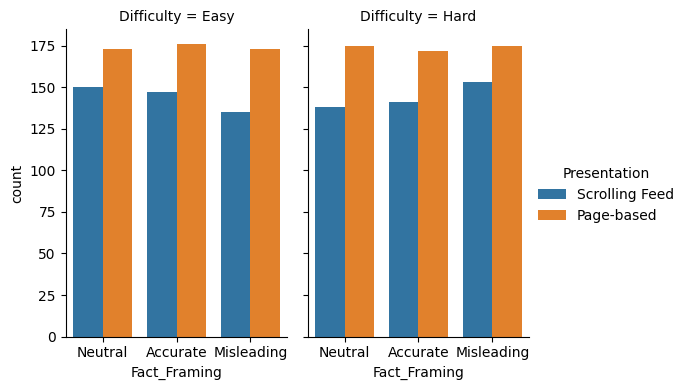

In [9]:
# Plot for Recall
sns.catplot(x='Fact_Framing', hue='Presentation', col='Difficulty', data=long_df, kind='count', height=4, aspect=0.7)
plt.show()

<ipython-input-10-d0b515800248>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Fact_Framing', y='Count', hue='Response_Type', ci='sd', data=recall_summary_melted)


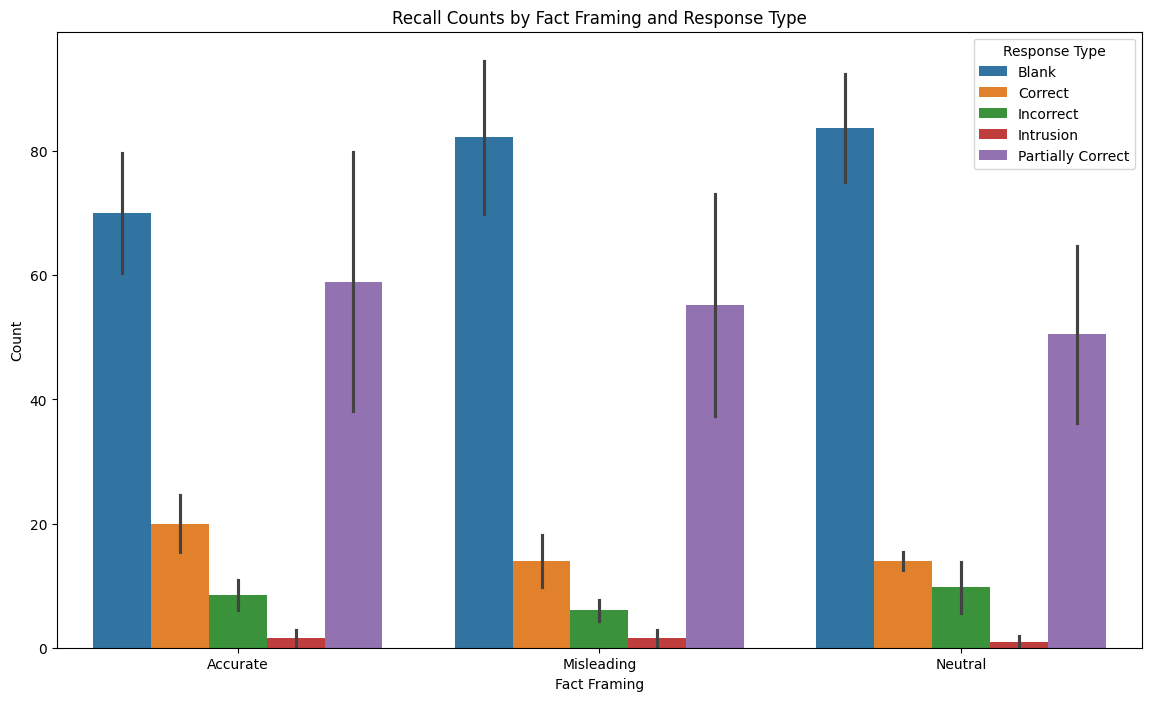

In [10]:
# Calculate summary statistics for recall
recall_summary = long_df.groupby(['Presentation', 'Difficulty', 'Fact_Framing', 'Decoded_Response']).size().unstack(fill_value=0).reset_index()
recall_summary_melted = recall_summary.melt(id_vars=['Presentation', 'Difficulty', 'Fact_Framing'], var_name='Response_Type', value_name='Count')

# Plot recall counts with standard deviation
plt.figure(figsize=(14, 8))
sns.barplot(x='Fact_Framing', y='Count', hue='Response_Type', ci='sd', data=recall_summary_melted)
plt.title('Recall Counts by Fact Framing and Response Type')
plt.xlabel('Fact Framing')
plt.ylabel('Count')
plt.legend(title='Response Type')
plt.show()

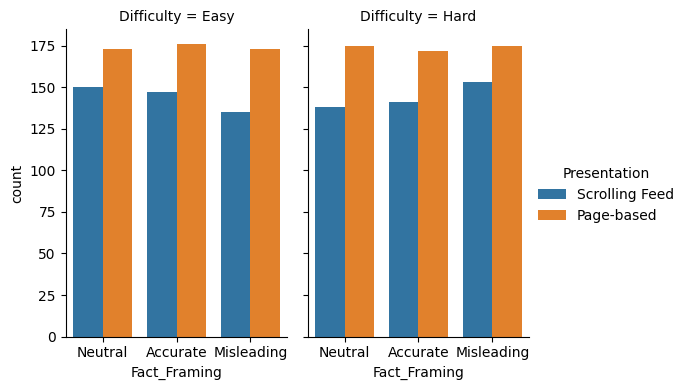

In [12]:
# Plot for Target Information Mentions
sns.catplot(x='Fact_Framing', hue='Presentation', col='Difficulty', data=long_df, kind='count', height=4, aspect=0.7)
plt.show()


<ipython-input-13-c7612b8c8c06>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Fact_Framing', y='Count', hue='Response_Type', ci='sd', data=target_summary_melted)


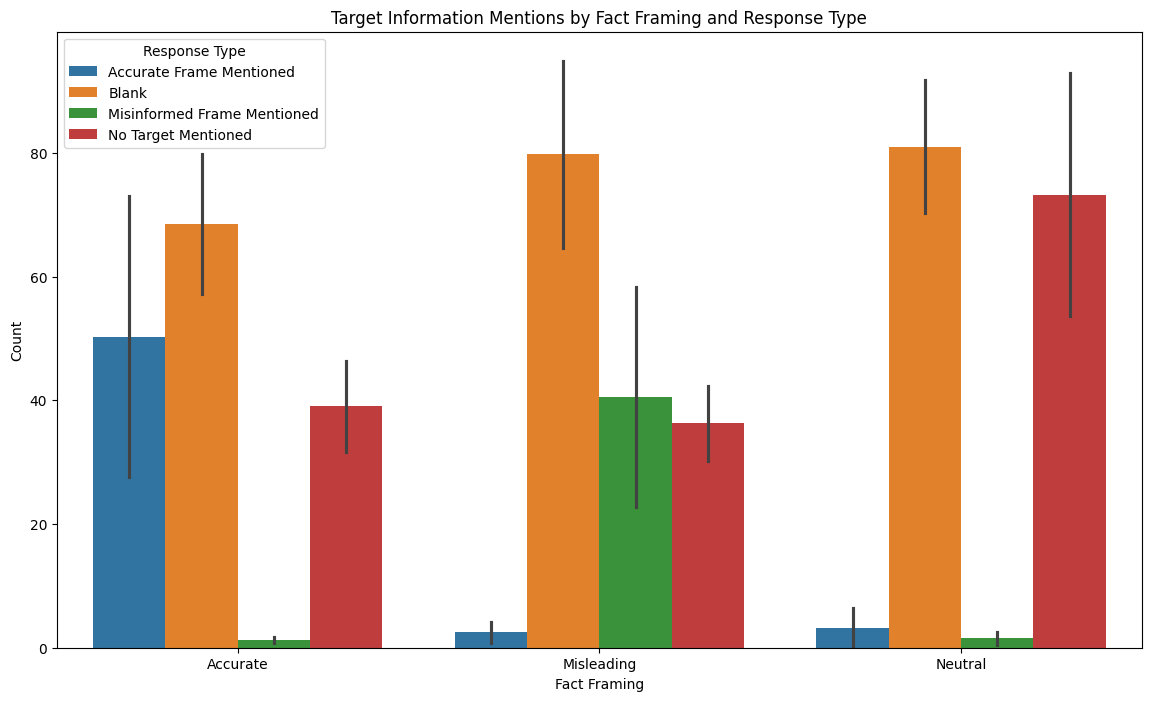

In [13]:
# Calculate summary statistics for target information mentions
target_summary = long_df.groupby(['Presentation', 'Difficulty', 'Fact_Framing', 'Decoded_Target_Response']).size().unstack(fill_value=0).reset_index()
target_summary_melted = target_summary.melt(id_vars=['Presentation', 'Difficulty', 'Fact_Framing'], var_name='Response_Type', value_name='Count')

# Plot target information mentions counts with standard deviation
plt.figure(figsize=(14, 8))
sns.barplot(x='Fact_Framing', y='Count', hue='Response_Type', ci='sd', data=target_summary_melted)
plt.title('Target Information Mentions by Fact Framing and Response Type')
plt.xlabel('Fact Framing')
plt.ylabel('Count')
plt.legend(title='Response Type')
plt.show()


<ipython-input-14-0abf2ad6912e>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(x='Fact_Framing', y='Count', hue='Response_Type', ci='sd', col='Presentation', row='Difficulty', data=recall_summary_melted, kind='bar', height=4, aspect=1.2)


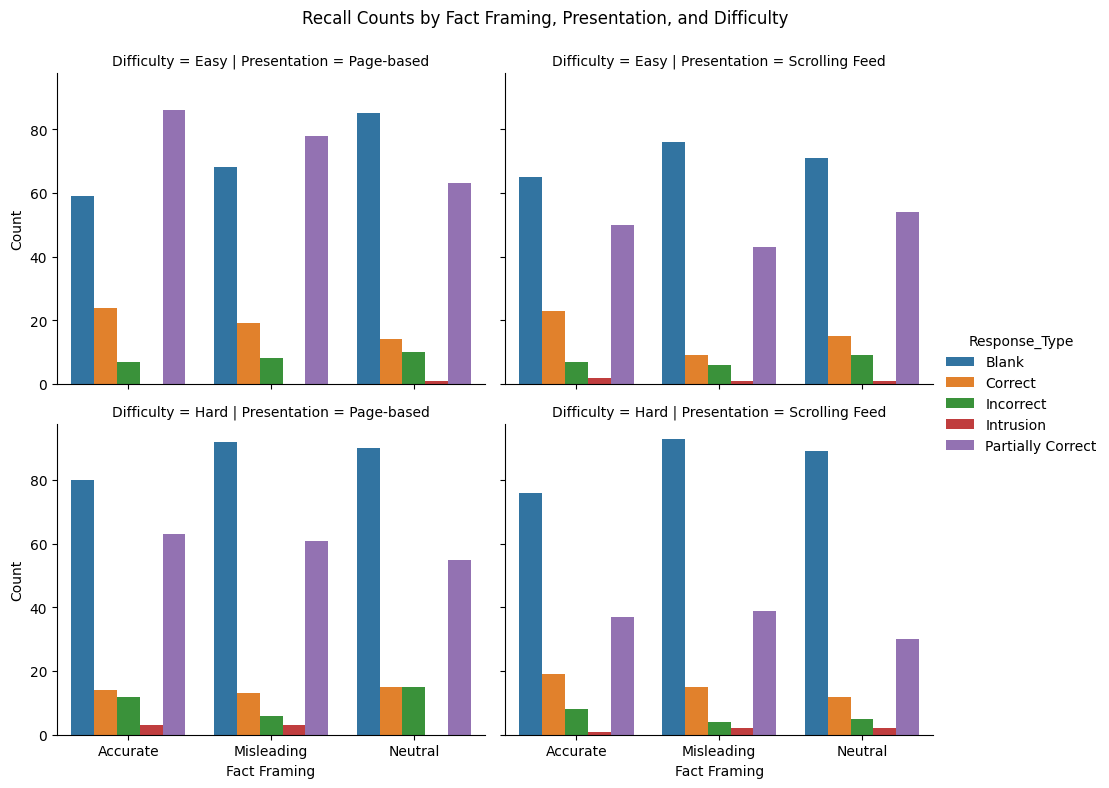

In [14]:
# Plot recall counts with standard deviation separated by presentation and difficulty
g = sns.catplot(x='Fact_Framing', y='Count', hue='Response_Type', ci='sd', col='Presentation', row='Difficulty', data=recall_summary_melted, kind='bar', height=4, aspect=1.2)
g.set_axis_labels("Fact Framing", "Count")
#g.add_legend(title='Response Type')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Recall Counts by Fact Framing, Presentation, and Difficulty')
plt.show()


<ipython-input-15-be7f1461b4b2>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(x='Fact_Framing', y='Count', hue='Response_Type', ci='sd', col='Presentation', row='Difficulty', data=target_summary_melted, kind='bar', height=4, aspect=1.2)


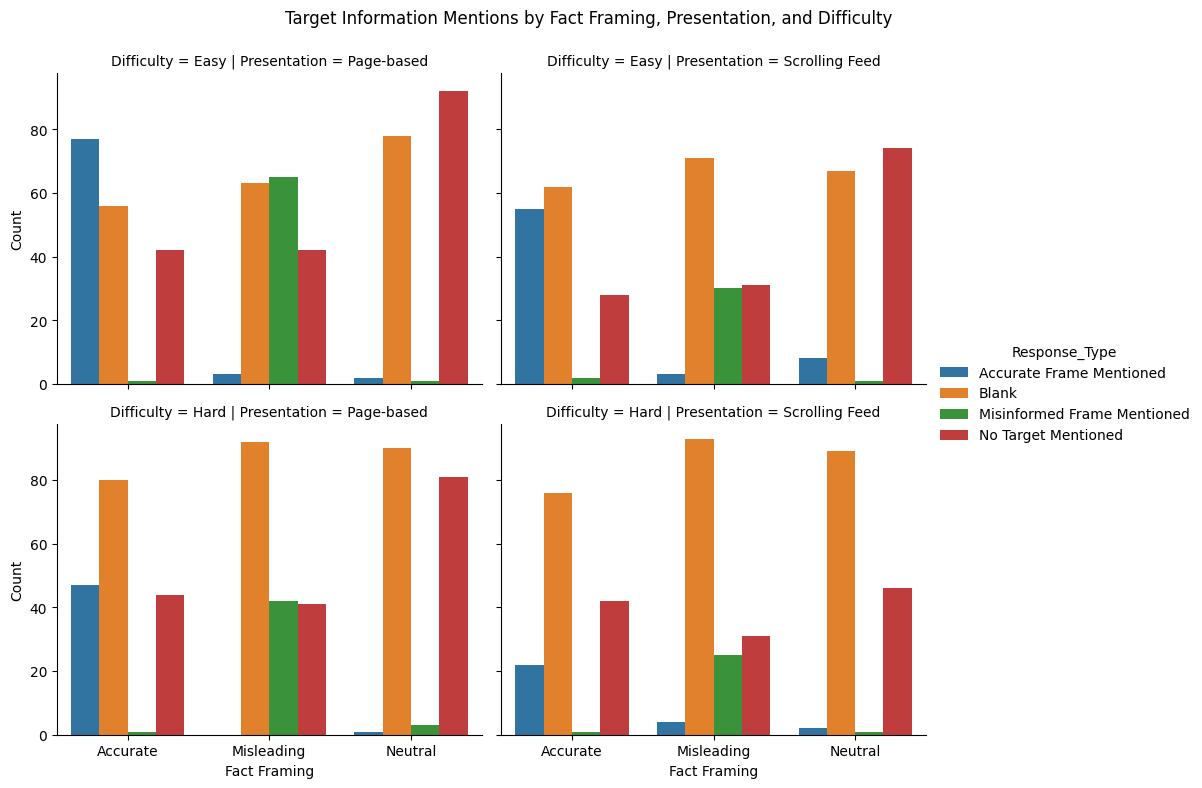

In [15]:
# Plot target information mentions counts with standard deviation separated by presentation and difficulty
g = sns.catplot(x='Fact_Framing', y='Count', hue='Response_Type', ci='sd', col='Presentation', row='Difficulty', data=target_summary_melted, kind='bar', height=4, aspect=1.2)
g.set_axis_labels("Fact Framing", "Count")
#g.add_legend(title='Response Type')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Target Information Mentions by Fact Framing, Presentation, and Difficulty')
plt.show()


<ipython-input-16-0632540029ab>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(x='Fact_Framing', y='Count', hue='Response_Type', ci='sd', col='Presentation', row='Difficulty', data=combined_summary_melted, kind='bar', height=4, aspect=1.2, hue_order=['Blank', 'Wrong', 'Correct', 'Misinformed', 'No Target Mentioned', 'Accurate Frame Mentioned', 'Misinformed Frame Mentioned'])


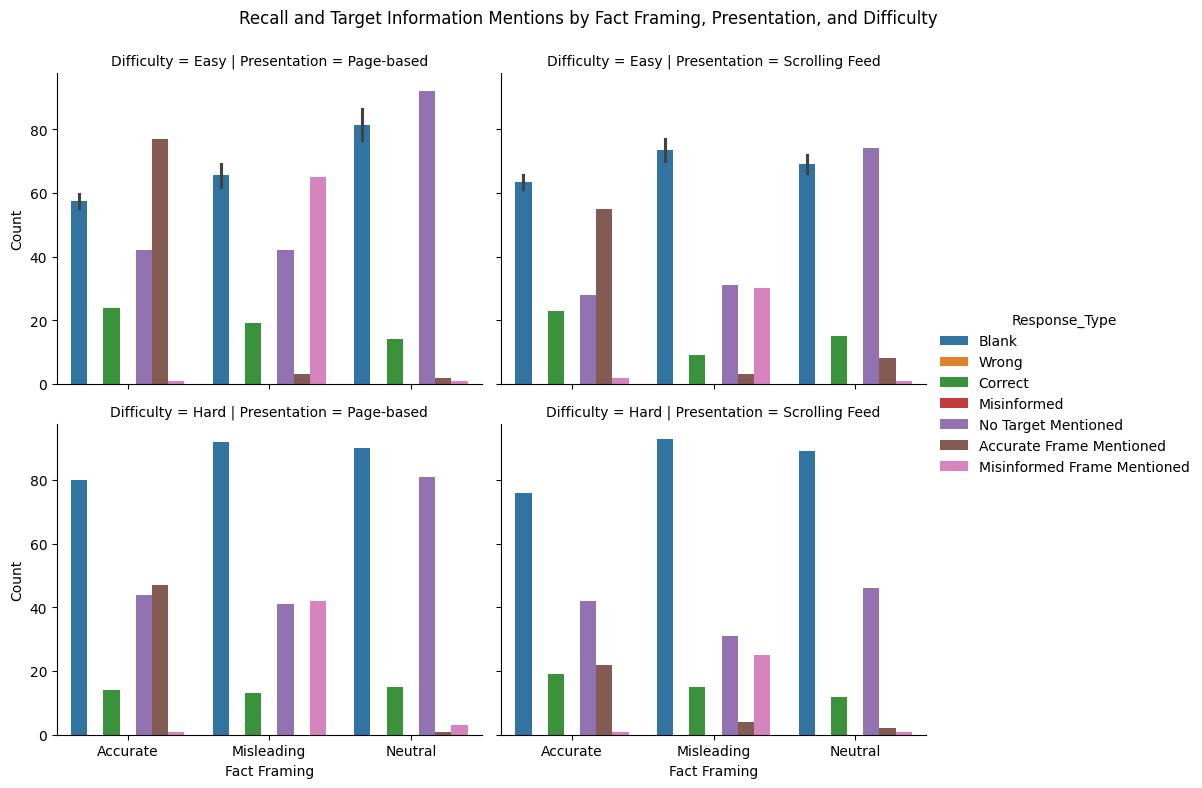

In [16]:
# Combine recall and target information mentions for a single plot
combined_summary_melted = pd.concat([recall_summary_melted.assign(Metric='Recall'), target_summary_melted.assign(Metric='Target Information Mentions')])

# Plot combined metrics with standard deviation
g = sns.catplot(x='Fact_Framing', y='Count', hue='Response_Type', ci='sd', col='Presentation', row='Difficulty', data=combined_summary_melted, kind='bar', height=4, aspect=1.2, hue_order=['Blank', 'Wrong', 'Correct', 'Misinformed', 'No Target Mentioned', 'Accurate Frame Mentioned', 'Misinformed Frame Mentioned'])
g.set_axis_labels("Fact Framing", "Count")
#g.add_legend(title='Response Type')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Recall and Target Information Mentions by Fact Framing, Presentation, and Difficulty')
plt.show()


## Analysis Prep

In [17]:
long_df

,ID,Presentation,Version,Duration_sec,Item,Response,Difficulty,Fact_Framing,Decoded_Response,Target_Response,Decoded_Target_Response
0,1,Scrolling Feed,C,525,GK1_coded,1,Easy,Neutral,Partially Correct,1,Accurate Frame Mentioned
1,2,Scrolling Feed,A,848,GK1_coded,1,Easy,Accurate,Partially Correct,0,No Target Mentioned
2,3,Page-based,B,1468,GK1_coded,1,Easy,Misleading,Partially Correct,2,Misinformed Frame Mentioned
3,4,Page-based,A,1378,GK1_coded,-99,Easy,Accurate,Blank,0,No Target Mentioned
4,5,Scrolling Feed,B,1238,GK1_coded,-99,Easy,Misleading,Blank,0,No Target Mentioned
...,...,...,...,...,...,...,...,...,...,...,...
1903,49,Page-based,A,2355,GK36_coded,1,Easy,Misleading,Partially Correct,2,Misinformed Frame Mentioned
1904,50,Page-based,A,3002,GK36_coded,0,Easy,Misleading,Incorrect,0,No Target Mentioned
1905,51,Scrolling Feed,A,3262,GK36_coded,-99,Easy,Misleading,Blank,-99,Blank
1906,52,Page-based,C,4587,GK36_coded,-99,Easy,Accurate,Blank,-99,Blank


In [18]:
# Binary coding for mixed effects analysis based on Target_Response
long_df['Correct_Binary'] = long_df['Target_Response'].apply(lambda x: 1 if x == 1 else 0)  # Accurate frame mentioned
long_df['Misinformed_Binary'] = long_df['Target_Response'].apply(lambda x: 1 if x == 2 else 0)  # Misinformed frame mentioned
long_df['Verbatim_Binary'] = long_df['Response'].apply(lambda x: 1 if x == 1 else 0)  # Partially correct (gist)
long_df['Gist_Binary'] = long_df['Response'].apply(lambda x: 1 if x == 2 else 0)  # Partially correct (gist)
long_df['Intrusion_Binary'] = long_df['Response'].apply(lambda x: 1 if x == 3 else 0)  # Intrusion

# Prepare the data for the proportion ANCOVA for each response type (Correct, Misinformed, Gist, Intrusion)
# Calculate the total number of items per participant
total_items_per_participant = long_df.groupby('ID')['Item'].count().reset_index()
total_items_per_participant.columns = ['ID', 'Total_Items']

# Calculate the counts of each Decoded_Response type per participant
response_counts = long_df.groupby(['ID', 'Decoded_Response']).size().unstack(fill_value=0).reset_index()

# Merge total items with response counts
response_proportions = pd.merge(response_counts, total_items_per_participant, on='ID')

# Calculate proportions
for response_type in ['Blank', 'Correct', 'Misinformed', 'Partially Correct', 'Intrusion']:
    if response_type not in response_proportions:
        response_proportions[response_type] = 0
    response_proportions[response_type] = response_proportions[response_type] / response_proportions['Total_Items']

# Merge the proportions back into the long_df to align with the rest of the data
long_df = pd.merge(long_df, response_proportions, on='ID', suffixes=('', '_Proportion'))

# Add Difficulty and Fact_Framing to proportions_df
proportions_df = long_df[['ID', 'Presentation', 'Duration_sec', 'Correct', 'Misinformed', 'Partially Correct', 'Intrusion']].drop_duplicates()

# Merge Difficulty and Fact_Framing information into proportions_df
difficulty_fact_framing_df = long_df[['ID', 'Difficulty', 'Fact_Framing']].drop_duplicates()
proportions_df = pd.merge(proportions_df, difficulty_fact_framing_df, on='ID')

# Convert to categorical type
proportions_df['Presentation'] = proportions_df['Presentation'].astype('category')
proportions_df['Difficulty'] = proportions_df['Difficulty'].astype('category')
proportions_df['Fact_Framing'] = proportions_df['Fact_Framing'].astype('category')

# Display the prepared DataFrame
print(proportions_df.head())

# Save this DataFrame for future reference
proportions_df.to_csv('exp1b_processed_proportions_df.csv', index=False)

# Save the combined long DataFrame for future reference
long_df.to_csv('exp1b_processed_long_df.csv', index=False)


  ID    Presentation  Duration_sec  Correct  Misinformed  Partially Correct  \
0  1  Scrolling Feed           525      0.0          0.0           0.583333   
1  1  Scrolling Feed           525      0.0          0.0           0.583333   
2  1  Scrolling Feed           525      0.0          0.0           0.583333   
3  1  Scrolling Feed           525      0.0          0.0           0.583333   
4  1  Scrolling Feed           525      0.0          0.0           0.583333   

   Intrusion Difficulty Fact_Framing  
0   0.027778       Easy      Neutral  
1   0.027778       Hard   Misleading  
2   0.027778       Hard     Accurate  
3   0.027778       Easy   Misleading  
4   0.027778       Hard      Neutral  


## Mixed Effects Logistic Regression

In [19]:
long_df

,ID,Presentation,Version,Duration_sec,Item,Response,Difficulty,Fact_Framing,Decoded_Response,Target_Response,...,Verbatim_Binary,Gist_Binary,Intrusion_Binary,Blank,Correct,Incorrect,Intrusion,Partially Correct,Total_Items,Misinformed
0,1,Scrolling Feed,C,525,GK1_coded,1,Easy,Neutral,Partially Correct,1,...,1,0,0,0.25,0.000000,5,0.027778,0.583333,36,0.0
1,1,Scrolling Feed,C,525,GK2_coded,1,Hard,Misleading,Partially Correct,2,...,1,0,0,0.25,0.000000,5,0.027778,0.583333,36,0.0
2,1,Scrolling Feed,C,525,GK3_coded,1,Hard,Accurate,Partially Correct,1,...,1,0,0,0.25,0.000000,5,0.027778,0.583333,36,0.0
3,1,Scrolling Feed,C,525,GK4_coded,1,Easy,Neutral,Partially Correct,2,...,1,0,0,0.25,0.000000,5,0.027778,0.583333,36,0.0
4,1,Scrolling Feed,C,525,GK5_coded,0,Easy,Misleading,Incorrect,0,...,0,0,0,0.25,0.000000,5,0.027778,0.583333,36,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,53,Scrolling Feed,C,4502,GK32_coded,1,Easy,Misleading,Partially Correct,0,...,1,0,0,0.00,0.027778,4,0.000000,0.861111,36,0.0
1904,53,Scrolling Feed,C,4502,GK33_coded,1,Hard,Accurate,Partially Correct,0,...,1,0,0,0.00,0.027778,4,0.000000,0.861111,36,0.0
1905,53,Scrolling Feed,C,4502,GK34_coded,1,Hard,Neutral,Partially Correct,0,...,1,0,0,0.00,0.027778,4,0.000000,0.861111,36,0.0
1906,53,Scrolling Feed,C,4502,GK35_coded,1,Easy,Misleading,Partially Correct,2,...,1,0,0,0.00,0.027778,4,0.000000,0.861111,36,0.0


### Recall: Accurate Frame Mentions

In [24]:
# Mixed effects logistic regression for Correct_Binary
model_correct = smf.mixedlm("Correct_Binary ~ Presentation * Difficulty * Fact_Framing + Duration_sec",
                            long_df, groups=long_df["ID"])
result_correct = model_correct.fit()
print(result_correct.summary())

                                         Mixed Linear Model Regression Results
Model:                                MixedLM                     Dependent Variable:                     Correct_Binary
No. Observations:                     1908                        Method:                                 REML          
No. Groups:                           53                          Scale:                                  0.0750        
Min. group size:                      36                          Log-Likelihood:                         -309.4531     
Max. group size:                      36                          Converged:                              Yes           
Mean group size:                      36.0                                                                              
------------------------------------------------------------------------------------------------------------------------
                                                                          

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [30]:
# Post Hoc for Correct Responses
# Convert columns to strings explicitly
presentation_fact_framing = long_df['Presentation'].astype(str) + ':' + long_df['Fact_Framing'].astype(str)
difficulty_fact_framing = long_df['Difficulty'].astype(str) + ':' + long_df['Fact_Framing'].astype(str)
presentation_difficulty_fact_framing = long_df['Presentation'].astype(str) + ':' + long_df['Difficulty'].astype(str) + ':' + long_df['Fact_Framing'].astype(str)

# Perform post-hoc analyses for the significant interaction between Presentation and Neutral Fact Framing
posthoc_presentation_neutral = mc.MultiComparison(long_df['Correct_Binary'], presentation_fact_framing)
posthoc_results_presentation_neutral = posthoc_presentation_neutral.tukeyhsd()
print("Post-hoc results for Presentation and Neutral Fact Framing (Correct):")
print(posthoc_results_presentation_neutral)

# Perform post-hoc analyses for the significant interaction between Difficulty and Misleading Fact Framing
posthoc_difficulty_misleading = mc.MultiComparison(long_df['Correct_Binary'], difficulty_fact_framing)
posthoc_results_difficulty_misleading = posthoc_difficulty_misleading.tukeyhsd()
print("Post-hoc results for Difficulty and Misleading Fact Framing (Correct):")
print(posthoc_results_difficulty_misleading)

# Perform post-hoc analyses for the significant interaction between Difficulty and Neutral Fact Framing
posthoc_difficulty_neutral = mc.MultiComparison(long_df['Correct_Binary'], difficulty_fact_framing)
posthoc_results_difficulty_neutral = posthoc_difficulty_neutral.tukeyhsd()
print("Post-hoc results for Difficulty and Neutral Fact Framing (Correct):")
print(posthoc_results_difficulty_neutral)

Post-hoc results for Presentation and Neutral Fact Framing (Correct):
                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
      Page-based:Accurate     Page-based:Misleading  -0.3477    0.0 -0.4102 -0.2852   True
      Page-based:Accurate        Page-based:Neutral  -0.3477    0.0 -0.4102 -0.2852   True
      Page-based:Accurate   Scrolling Feed:Accurate   -0.089 0.0016 -0.1546 -0.0233   True
      Page-based:Accurate Scrolling Feed:Misleading   -0.332    0.0 -0.3976 -0.2664   True
      Page-based:Accurate    Scrolling Feed:Neutral  -0.3216    0.0 -0.3872  -0.256   True
    Page-based:Misleading        Page-based:Neutral      0.0    1.0 -0.0625  0.0625  False
    Page-based:Misleading   Scrolling Feed:Accurate   0.2587    0.0  0.1931  0.3244   True
    Page-based:Misle

### Recall: Misleading Frame Mentions

In [25]:
# Mixed effects logistic regression for Misinformed_Binary
model_misinformed = smf.mixedlm("Misinformed_Binary ~ Presentation * Difficulty * Fact_Framing + Duration_sec",
                                long_df, groups=long_df["ID"])
result_misinformed = model_misinformed.fit()
print(result_misinformed.summary())

                                         Mixed Linear Model Regression Results
Model:                               MixedLM                   Dependent Variable:                   Misinformed_Binary
No. Observations:                    1908                      Method:                               REML              
No. Groups:                          53                        Scale:                                0.0643            
Min. group size:                     36                        Log-Likelihood:                       -155.6912         
Max. group size:                     36                        Converged:                            Yes               
Mean group size:                     36.0                                                                              
-----------------------------------------------------------------------------------------------------------------------
                                                                             Coef

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [31]:
# Post-hoc analyses for Presentation and Fact Framing
presentation_fact_framing = long_df['Presentation'].astype(str) + ':' + long_df['Fact_Framing'].astype(str)
posthoc = mc.MultiComparison(long_df['Misinformed_Binary'], presentation_fact_framing)
posthoc_results = posthoc.tukeyhsd()
print("Post-hoc results for Presentation and Fact Framing (Misinformed):")
print(posthoc_results)

# Post-hoc analyses for Difficulty and Fact Framing
difficulty_fact_framing = long_df['Difficulty'].astype(str) + ':' + long_df['Fact_Framing'].astype(str)
posthoc = mc.MultiComparison(long_df['Misinformed_Binary'], difficulty_fact_framing)
posthoc_results = posthoc.tukeyhsd()
print("Post-hoc results for Difficulty and Fact Framing (Misinformed):")
print(posthoc_results)

Post-hoc results for Presentation and Fact Framing (Misinformed):
                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
      Page-based:Accurate     Page-based:Misleading   0.3017    0.0  0.2453  0.3582   True
      Page-based:Accurate        Page-based:Neutral   0.0057 0.9997 -0.0507  0.0622  False
      Page-based:Accurate   Scrolling Feed:Accurate   0.0047 0.9999 -0.0546   0.064  False
      Page-based:Accurate Scrolling Feed:Misleading   0.1852    0.0  0.1259  0.2445   True
      Page-based:Accurate    Scrolling Feed:Neutral   0.0012    1.0 -0.0581  0.0605  False
    Page-based:Misleading        Page-based:Neutral   -0.296    0.0 -0.3524 -0.2395   True
    Page-based:Misleading   Scrolling Feed:Accurate  -0.2971    0.0 -0.3563 -0.2378   True
    Page-based:Misleadin

### Recall: Partially Correct/Gist

In [26]:
# Mixed effects logistic regression for Gist_Binary
model_gist = smf.mixedlm("Gist_Binary ~ Presentation * Difficulty * Fact_Framing + Duration_sec",
                         long_df, groups=long_df["ID"])
result_gist = model_gist.fit()
print(result_gist.summary())

                                         Mixed Linear Model Regression Results
Model:                                  MixedLM                     Dependent Variable:                     Gist_Binary
No. Observations:                       1908                        Method:                                 REML       
No. Groups:                             53                          Scale:                                  0.0734     
Min. group size:                        36                          Log-Likelihood:                         -312.3081  
Max. group size:                        36                          Converged:                              Yes        
Mean group size:                        36.0                                                                           
-----------------------------------------------------------------------------------------------------------------------
                                                                             Coef

In [ ]:
#### No post hocs needed

### Recall: Correct/Verbatim

In [27]:
# Mixed effects logistic regression for Verbatim_Binary
model_verbatim = smf.mixedlm("Verbatim_Binary ~ Presentation * Difficulty * Fact_Framing + Duration_sec",
                             long_df, groups=long_df["ID"])
result_verbatim = model_verbatim.fit()
print(result_verbatim.summary())

                                         Mixed Linear Model Regression Results
Model:                                MixedLM                    Dependent Variable:                    Verbatim_Binary
No. Observations:                     1908                       Method:                                REML           
No. Groups:                           53                         Scale:                                 0.1744         
Min. group size:                      36                         Log-Likelihood:                        -1135.9995     
Max. group size:                      36                         Converged:                             Yes            
Mean group size:                      36.0                                                                             
-----------------------------------------------------------------------------------------------------------------------
                                                                             Coef

In [ ]:
#### No post hocs needed

### Recall: Intrusions

In [28]:
# Mixed effects logistic regression for Intrusion_Binary
model_intrusion = smf.mixedlm("Intrusion_Binary ~ Presentation * Difficulty * Fact_Framing + Duration_sec",
                              long_df, groups=long_df["ID"])
result_intrusion = model_intrusion.fit()
print(result_intrusion.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                                         Mixed Linear Model Regression Results
Model:                               MixedLM                    Dependent Variable:                    Intrusion_Binary
No. Observations:                    1908                       Method:                                REML            
No. Groups:                          53                         Scale:                                 0.0082          
Min. group size:                     36                         Log-Likelihood:                        1808.4975       
Max. group size:                     36                         Converged:                             Yes             
Mean group size:                     36.0                                                                              
-----------------------------------------------------------------------------------------------------------------------
                                                                             Coef

In [ ]:
#### No post hocs needed

## Proportion Based ANCOVA

In [34]:
# Unique rows for each participant and condition combination
proportions_df = long_df[['ID', 'Presentation', 'Duration_sec', 'Difficulty', 'Fact_Framing']].drop_duplicates()

# Calculate proportions for each response type
response_types = ['Correct_Binary', 'Misinformed_Binary', 'Gist_Binary', 'Verbatim_Binary', 'Intrusion_Binary']
for response_type in response_types:
    prop_col = f'{response_type}_Proportion'
    proportions = long_df.groupby('ID')[response_type].mean().reset_index()
    proportions.columns = ['ID', prop_col]
    proportions_df = pd.merge(proportions_df, proportions, on='ID')

# Convert to categorical type
proportions_df['Presentation'] = proportions_df['Presentation'].astype('category')
proportions_df['Difficulty'] = proportions_df['Difficulty'].astype('category')
proportions_df['Fact_Framing'] = proportions_df['Fact_Framing'].astype('category')

# Display the prepared DataFrame
print(proportions_df.head())

  ID    Presentation  Duration_sec Difficulty Fact_Framing  \
0  1  Scrolling Feed           525       Easy      Neutral   
1  1  Scrolling Feed           525       Hard   Misleading   
2  1  Scrolling Feed           525       Hard     Accurate   
3  1  Scrolling Feed           525       Easy   Misleading   
4  1  Scrolling Feed           525       Hard      Neutral   

   Correct_Binary_Proportion  Misinformed_Binary_Proportion  \
0                   0.416667                       0.138889   
1                   0.416667                       0.138889   
2                   0.416667                       0.138889   
3                   0.416667                       0.138889   
4                   0.416667                       0.138889   

   Gist_Binary_Proportion  Verbatim_Binary_Proportion  \
0                     0.0                    0.583333   
1                     0.0                    0.583333   
2                     0.0                    0.583333   
3                   

In [43]:
# Check column names in proportions_df
print(proportions_df.columns)

# Adjust column names if necessary
proportions_df.rename(columns={
    'Misinformed_Binary_Proportion': 'Misinformed',
    'Gist_Binary_Proportion': 'Gist',
    'Correct_Binary_Proportion': 'Correct',
    'Verbatim_Binary_Proportion': 'Verbatim',
    'Intrusion_Binary_Proportion': 'Intrusion'
}, inplace=True)

Index(['ID', 'Presentation', 'Duration_sec', 'Difficulty', 'Fact_Framing',
       'Correct', 'Misinformed', 'Gist', 'Verbatim', 'Intrusion'],
      dtype='object')


In [36]:
# Make a function to perform ANCOVA
def run_ancova(df, response_var, covariate, factors):
    formula = f'{response_var} ~ {" + ".join(factors)} + {covariate}'
    model = smf.ols(formula, data=df).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    return model, aov_table

# Define the covariate and factors
covariate = 'Duration_sec'
factors = ['Presentation', 'Difficulty', 'Fact_Framing']

# Run ANCOVA for each response type
response_vars = ['Correct_Binary_Proportion', 'Misinformed_Binary_Proportion', 'Gist_Binary_Proportion', 'Verbatim_Binary_Proportion', 'Intrusion_Binary_Proportion']
results = {}

for response_var in response_vars:
    model, aov_table = run_ancova(proportions_df, response_var, covariate, factors)
    results[response_var] = (model, aov_table)
    print(f'ANCOVA results for {response_var}:')
    print(aov_table)
    print('\n')

ANCOVA results for Correct_Binary_Proportion:
                    sum_sq     df             F    PR(>F)
Presentation  2.171105e-02    1.0  2.889602e+00  0.090150
Difficulty    2.901450e-31    1.0  3.861645e-29  1.000000
Fact_Framing  5.039804e-33    2.0  3.353829e-31  1.000000
Duration_sec  3.353646e-03    1.0  4.463490e-01  0.504568
Residual      2.344214e+00  312.0           NaN       NaN


ANCOVA results for Misinformed_Binary_Proportion:
                    sum_sq     df             F    PR(>F)
Presentation  1.062911e-01    1.0  2.243213e+01  0.000003
Difficulty    8.478271e-32    1.0  1.789291e-29  1.000000
Fact_Framing  2.963453e-32    2.0  3.127100e-30  1.000000
Duration_sec  6.312020e-03    1.0  1.332116e+00  0.249312
Residual      1.478362e+00  312.0           NaN       NaN


ANCOVA results for Gist_Binary_Proportion:
                    sum_sq     df             F    PR(>F)
Presentation  2.539149e-02    1.0  1.340327e+00  0.247862
Difficulty    4.589400e-31    1.0  2.422582e-

In [42]:
# Post Hoc for Misinformed Responses
mc_misinformed = mc.MultiComparison(proportions_df['Misinformed'], proportions_df['Presentation'].astype(str) + ':' + proportions_df['Difficulty'].astype(str) + ':' + proportions_df['Fact_Framing'].astype(str))
posthoc_misinformed_results = mc_misinformed.tukeyhsd()
print("Post-hoc results for Misinformed Responses:")
print(posthoc_misinformed_results)

# Post Hoc for Verbatim Responses
mc_verbatim = mc.MultiComparison(proportions_df['Verbatim'], proportions_df['Presentation'].astype(str) + ':' + proportions_df['Difficulty'].astype(str) + ':' + proportions_df['Fact_Framing'].astype(str))
posthoc_verbatim_results = mc_verbatim.tukeyhsd()
print("Post-hoc results for Verbatim Responses:")
print(posthoc_verbatim_results)

# Post Hoc for Intrusion Responses
mc_intrusion = MultiComparison(proportions_df['Intrusion'], proportions_df['Presentation'].astype(str) + ':' + proportions_df['Difficulty'].astype(str) + ':' + proportions_df['Fact_Framing'].astype(str))
posthoc_intrusion_results = mc_intrusion.tukeyhsd()
print("Post-hoc results for Intrusion Responses:")
print(posthoc_intrusion_results)

Post-hoc results for Misinformed Responses:
                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                        
            group1                         group2             meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------------------------------------
      Page-based:Easy:Accurate     Page-based:Easy:Misleading      0.0    1.0 -0.0602 0.0602  False
      Page-based:Easy:Accurate        Page-based:Easy:Neutral      0.0    1.0 -0.0602 0.0602  False
      Page-based:Easy:Accurate       Page-based:Hard:Accurate      0.0    1.0 -0.0602 0.0602  False
      Page-based:Easy:Accurate     Page-based:Hard:Misleading      0.0    1.0 -0.0602 0.0602  False
      Page-based:Easy:Accurate        Page-based:Hard:Neutral      0.0    1.0 -0.0602 0.0602  False
      Page-based:Easy:Accurate   Scrolling Feed:Easy:Accurate  -0.0388 0.6807 -0.1021 0.0245  False
      Page-based:Easy:Accurate Scrolling Feed:Easy:Misle

## ANCOVA Diagnostics

ANCOVA results for Correct Responses:
                                            sum_sq     df             F  \
Presentation                          2.171105e-02    1.0  2.824771e+00   
Difficulty                            1.389215e-31    1.0  1.807473e-29   
Fact_Framing                          3.342437e-31    2.0  2.174382e-29   
Presentation:Difficulty               1.696652e-31    1.0  2.207472e-29   
Presentation:Fact_Framing             2.520682e-31    2.0  1.639799e-29   
Difficulty:Fact_Framing               1.429057e-32    2.0  9.296553e-31   
Presentation:Difficulty:Fact_Framing  1.716095e-30    2.0  1.116384e-28   
Duration_sec                          3.353646e-03    1.0  4.363347e-01   
Residual                              2.344214e+00  305.0           NaN   

                                        PR(>F)  
Presentation                          0.093844  
Difficulty                            1.000000  
Fact_Framing                          1.000000  
Presentation:Di

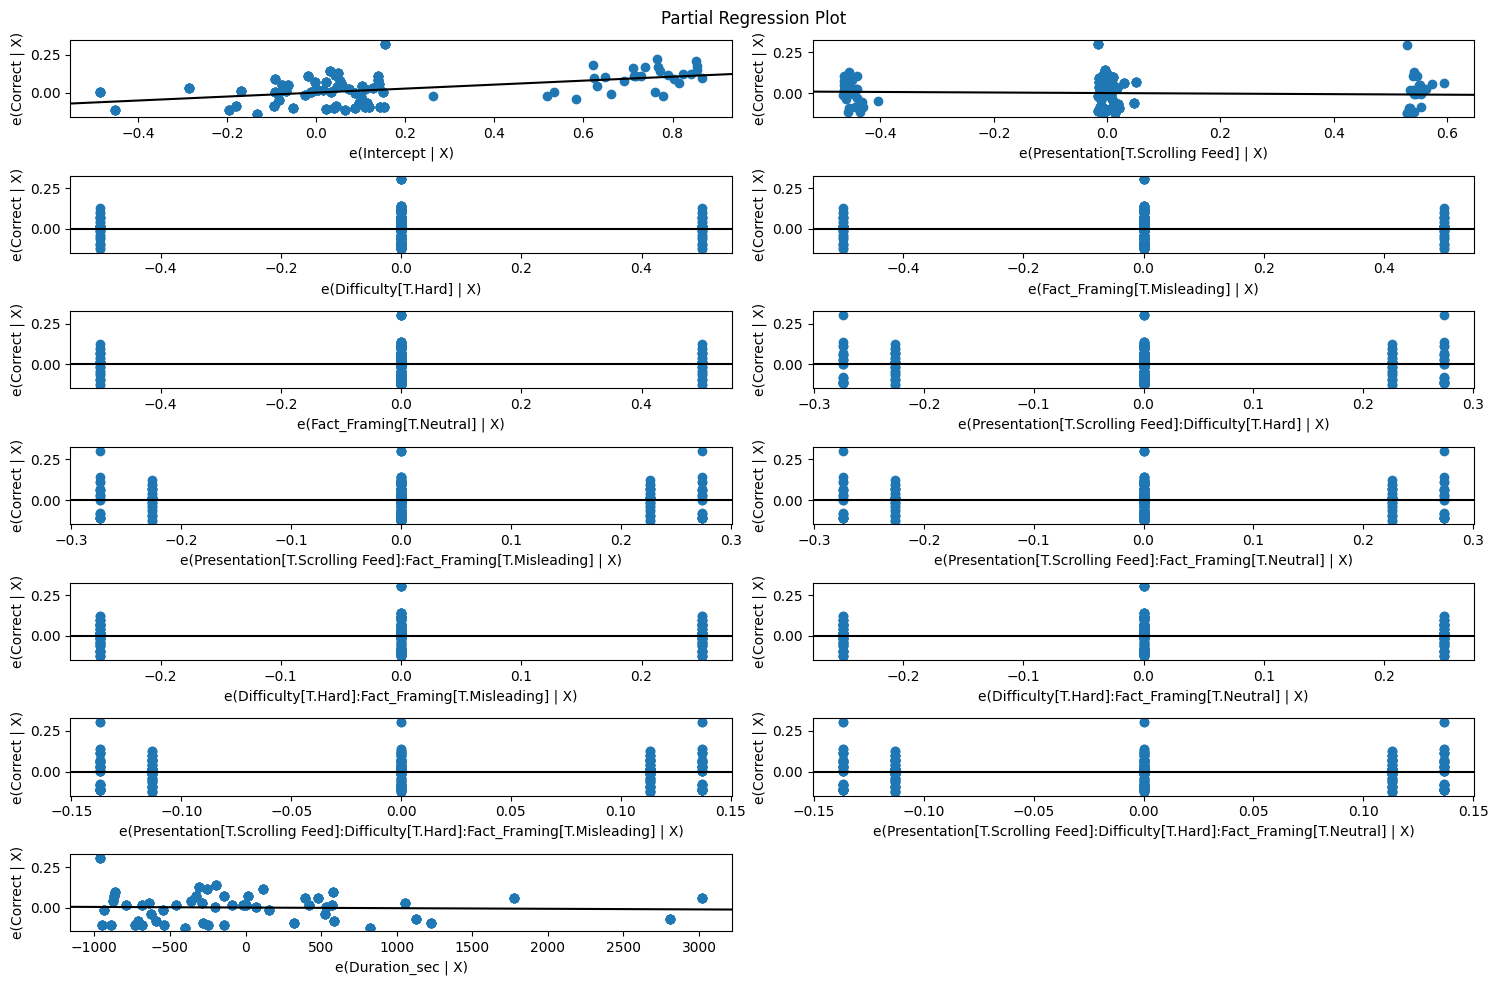

Breusch-Pagan test p-value for Correct model: 0.001534370118817805


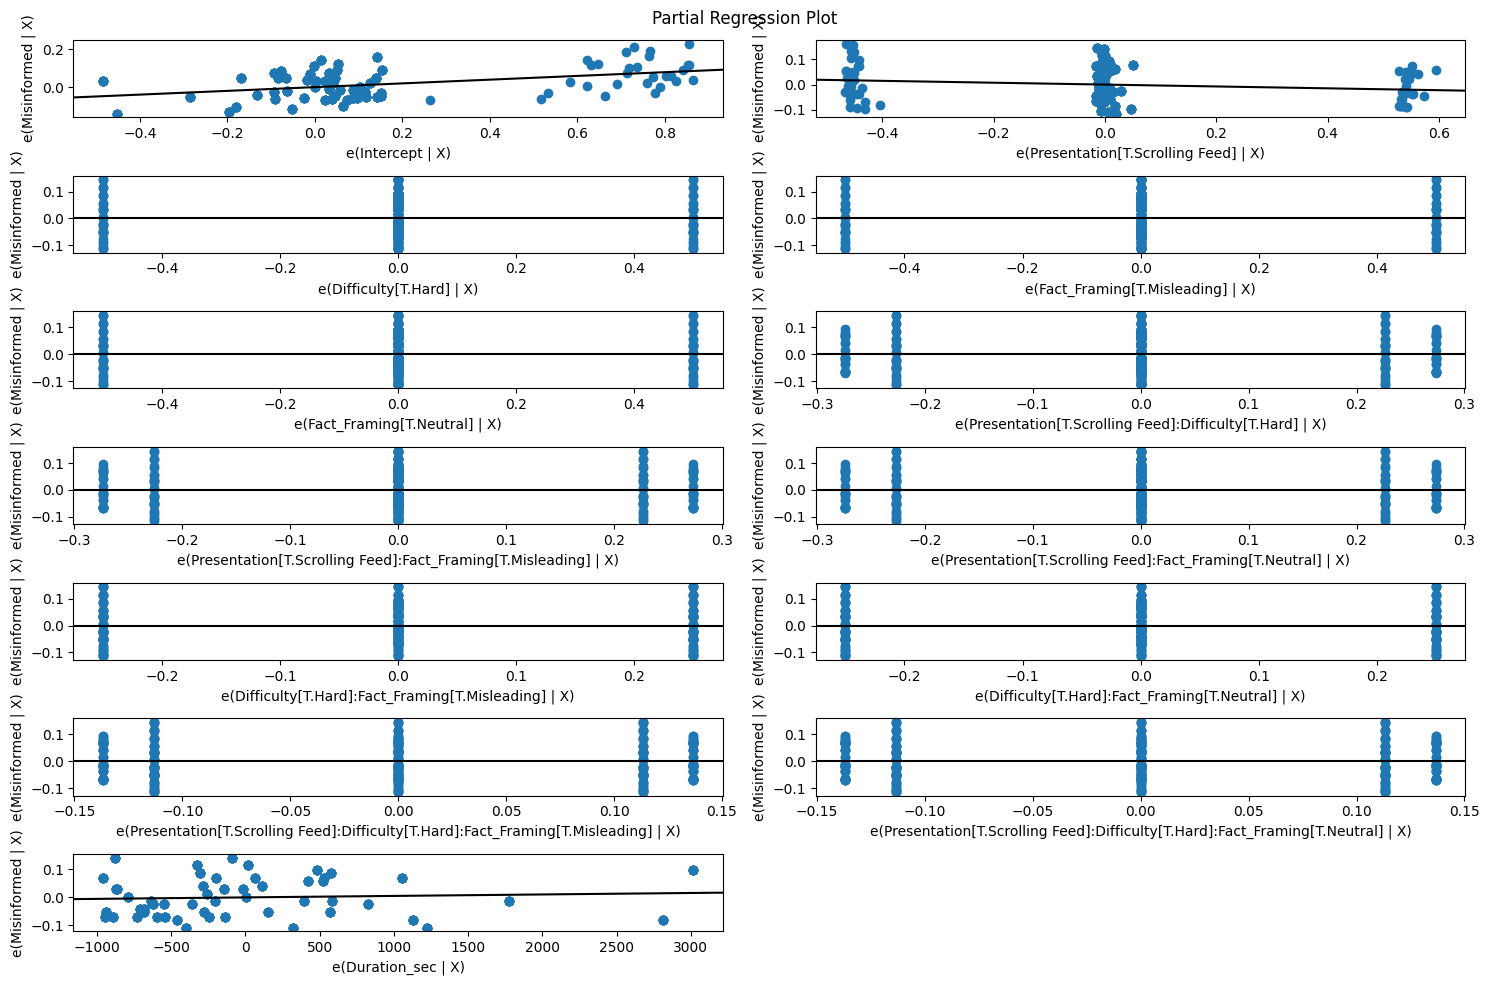

Breusch-Pagan test p-value for Misinformed model: 0.008560022597469656


In [46]:
# Define the formula for the ANCOVA
formula_correct = 'Correct ~ Presentation * Difficulty * Fact_Framing + Duration_sec'
formula_misinformed = 'Misinformed ~ Presentation * Difficulty * Fact_Framing + Duration_sec'

# Run the ANCOVA for Correct responses
model_correct_ancova = smf.ols(formula_correct, data=proportions_df).fit()
aov_table_correct = sm.stats.anova_lm(model_correct_ancova, typ=2)

# Run the ANCOVA for Misinformed responses
model_misinformed_ancova = smf.ols(formula_misinformed, data=proportions_df).fit()
aov_table_misinformed = sm.stats.anova_lm(model_misinformed_ancova, typ=2)

# Print the ANOVA tables
print("ANCOVA results for Correct Responses:")
print(aov_table_correct)

print("\nANCOVA results for Misinformed Responses:")
print(aov_table_misinformed)

# Plot diagnostics for the ANCOVA model for correct responses
fig = plt.figure(figsize=(15, 10))
fig = sm.graphics.plot_partregress_grid(model_correct_ancova, fig=fig)
plt.show()

# Check for homoscedasticity using Breusch-Pagan test
_, pval_correct, __, f_pval_correct = sm.stats.diagnostic.het_breuschpagan(model_correct_ancova.resid, model_correct_ancova.model.exog)
print(f"Breusch-Pagan test p-value for Correct model: {pval_correct}")

# Plot diagnostics for the ANCOVA model for misinformed responses
fig = plt.figure(figsize=(15, 10))
fig = sm.graphics.plot_partregress_grid(model_misinformed_ancova, fig=fig)
plt.show()

# Check for homoscedasticity using Breusch-Pagan test
_, pval_misinformed, __, f_pval_misinformed = sm.stats.diagnostic.het_breuschpagan(model_misinformed_ancova.resid, model_misinformed_ancova.model.exog)
print(f"Breusch-Pagan test p-value for Misinformed model: {pval_misinformed}")


## Effect Sizes

In [47]:
# Define a function to calculate Hedge's g
def hedges_g(mean1, mean2, sd1, sd2, n1, n2):
    pooled_sd = np.sqrt(((n1 - 1) * sd1 ** 2 + (n2 - 1) * sd2 ** 2) / (n1 + n2 - 2))
    g = (mean1 - mean2) / pooled_sd
    correction_factor = 1 - (3 / (4 * (n1 + n2) - 9))
    hedges_g_value = g * correction_factor
    return hedges_g_value

# Group by Presentation, Difficulty, and Fact Framing
grouped_lme = long_df.groupby(['Presentation', 'Difficulty', 'Fact_Framing'])

# Calculate means, standard deviations, and sample sizes
means_lme = grouped_lme['Correct_Binary'].mean()
sds_lme = grouped_lme['Correct_Binary'].std()
ns_lme = grouped_lme['Correct_Binary'].count()

# Define pairs for Hedge's g calculation based on significant results
significant_pairs_lme = [
    ('Scrolling Feed', 'Easy', 'Accurate', 'Page-based', 'Easy', 'Accurate'),
    ('Scrolling Feed', 'Easy', 'Misleading', 'Page-based', 'Easy', 'Misleading'),
    ('Scrolling Feed', 'Easy', 'Accurate', 'Scrolling Feed', 'Hard', 'Accurate'),
    ('Page-based', 'Easy', 'Accurate', 'Page-based', 'Hard', 'Accurate'),
    ('Scrolling Feed', 'Easy', 'Misleading', 'Scrolling Feed', 'Hard', 'Misleading'),
    ('Page-based', 'Easy', 'Misleading', 'Page-based', 'Hard', 'Misleading'),
    ('Scrolling Feed', 'Easy', 'Accurate', 'Scrolling Feed', 'Easy', 'Misleading'),
    ('Page-based', 'Easy', 'Accurate', 'Page-based', 'Easy', 'Misleading'),
    ('Scrolling Feed', 'Hard', 'Accurate', 'Scrolling Feed', 'Hard', 'Misleading'),
    ('Page-based', 'Hard', 'Accurate', 'Page-based', 'Hard', 'Misleading')
]

# Calculate Hedge's g for each pair
hedges_g_values_lme = {}
for (p1, d1, f1, p2, d2, f2) in significant_pairs_lme:
    mean1, mean2 = means_lme.loc[(p1, d1, f1)], means_lme.loc[(p2, d2, f2)]
    sd1, sd2 = sds_lme.loc[(p1, d1, f1)], sds_lme.loc[(p2, d2, f2)]
    n1, n2 = ns_lme.loc[(p1, d1, f1)], ns_lme.loc[(p2, d2, f2)]
    g = hedges_g(mean1, mean2, sd1, sd2, n1, n2)
    hedges_g_values_lme[((p1, d1, f1), (p2, d2, f2))] = g

# Print Hedge's g values
print("Hedge's g for Mixed Effects Model:")
for groups, g_value in hedges_g_values_lme.items():
    print(f"Hedge's g for {groups}: {g_value}")

# Group by Presentation, Difficulty, and Fact Framing for proportions
grouped_proportions = proportions_df.groupby(['Presentation', 'Difficulty', 'Fact_Framing'])

# Calculate means, standard deviations, and sample sizes for proportions
means_proportions = grouped_proportions['Correct'].mean()
sds_proportions = grouped_proportions['Correct'].std()
ns_proportions = grouped_proportions['Correct'].count()

# Calculate Hedge's g for Proportions
hedges_g_values_proportions = {}
for (p1, d1, f1, p2, d2, f2) in significant_pairs_lme:
    mean1, mean2 = means_proportions.loc[(p1, d1, f1)], means_proportions.loc[(p2, d2, f2)]
    sd1, sd2 = sds_proportions.loc[(p1, d1, f1)], sds_proportions.loc[(p2, d2, f2)]
    n1, n2 = ns_proportions.loc[(p1, d1, f1)], ns_proportions.loc[(p2, d2, f2)]
    g = hedges_g(mean1, mean2, sd1, sd2, n1, n2)
    hedges_g_values_proportions[((p1, d1, f1), (p2, d2, f2))] = g

print("Hedge's g for Proportions:")
for groups, g_value in hedges_g_values_proportions.items():
    print(f"Hedge's g for {groups}: {g_value}")

Hedge's g for Mixed Effects Model:
Hedge's g for (('Scrolling Feed', 'Easy', 'Accurate'), ('Page-based', 'Easy', 'Accurate')): -0.1284335603243762
Hedge's g for (('Scrolling Feed', 'Easy', 'Misleading'), ('Page-based', 'Easy', 'Misleading')): 0.03512222518817452
Hedge's g for (('Scrolling Feed', 'Easy', 'Accurate'), ('Scrolling Feed', 'Hard', 'Accurate')): 0.5054128071867668
Hedge's g for (('Page-based', 'Easy', 'Accurate'), ('Page-based', 'Hard', 'Accurate')): 0.3463535550061188
Hedge's g for (('Scrolling Feed', 'Easy', 'Misleading'), ('Scrolling Feed', 'Hard', 'Misleading')): -0.025312240634158583
Hedge's g for (('Page-based', 'Easy', 'Misleading'), ('Page-based', 'Hard', 'Misleading')): 0.1874597660949038
Hedge's g for (('Scrolling Feed', 'Easy', 'Accurate'), ('Scrolling Feed', 'Easy', 'Misleading')): 0.9609289722229821
Hedge's g for (('Page-based', 'Easy', 'Accurate'), ('Page-based', 'Easy', 'Misleading')): 1.148240716078555
Hedge's g for (('Scrolling Feed', 'Hard', 'Accurate'), ('

## All the Plots

In [48]:
# Define a function to save the plots
def save_plot(fig, filename):
    fig.savefig(filename, bbox_inches='tight')

### Misleading Mentions

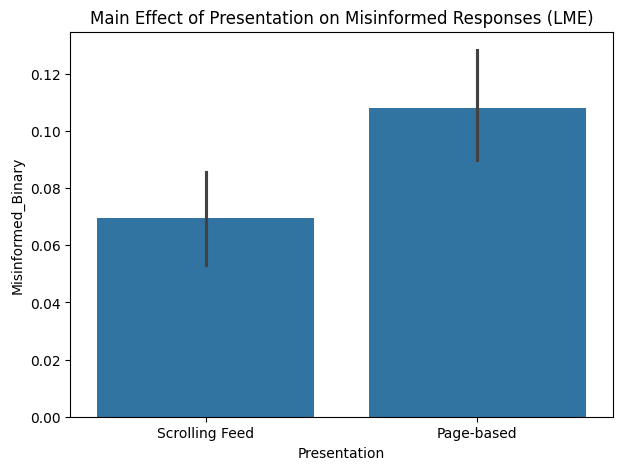

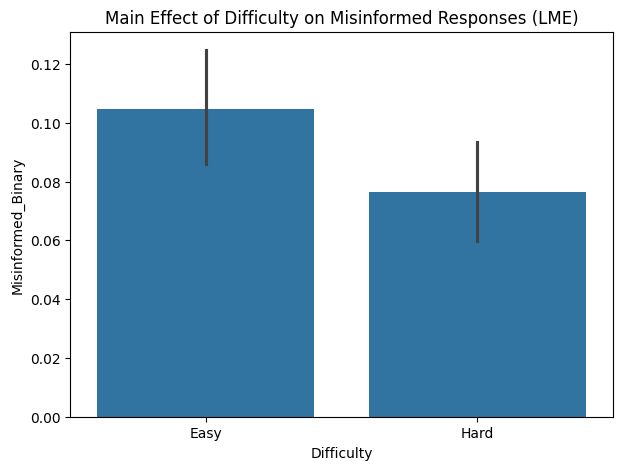

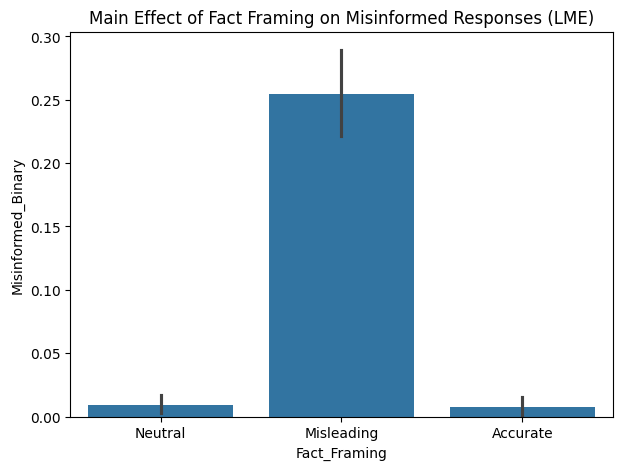

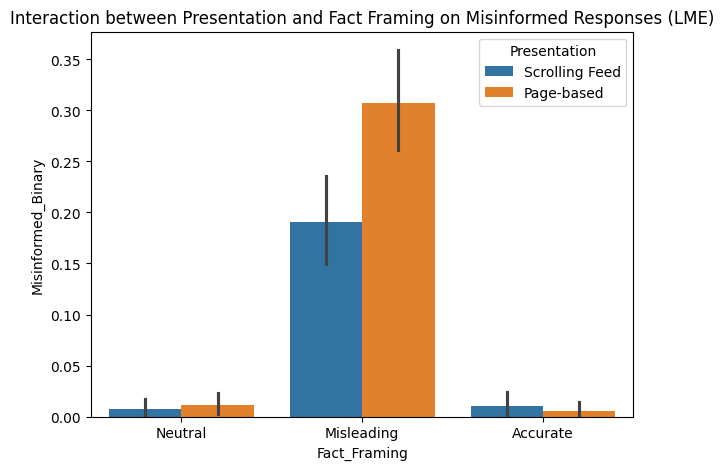

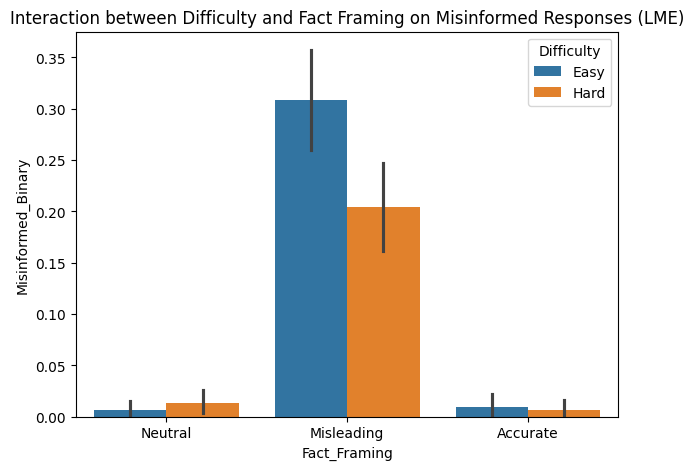

In [49]:
# Main effect of Presentation on Misinformed Responses
fig1 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Presentation', y='Misinformed_Binary')
plt.title('Main Effect of Presentation on Misinformed Responses (LME)')
save_plot(fig1, 'main_effect_presentation_misinformed_lme.png')
plt.show()

# Main effect of Difficulty on Misinformed Responses
fig2 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Difficulty', y='Misinformed_Binary')
plt.title('Main Effect of Difficulty on Misinformed Responses (LME)')
save_plot(fig2, 'main_effect_difficulty_misinformed_lme.png')
plt.show()

# Main effect of Fact Framing on Misinformed Responses
fig3 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Misinformed_Binary')
plt.title('Main Effect of Fact Framing on Misinformed Responses (LME)')
save_plot(fig3, 'main_effect_fact_framing_misinformed_lme.png')
plt.show()

# Interaction between Presentation and Fact Framing on Misinformed Responses
fig4 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Misinformed_Binary', hue='Presentation')
plt.title('Interaction between Presentation and Fact Framing on Misinformed Responses (LME)')
save_plot(fig4, 'interaction_presentation_fact_framing_misinformed_lme.png')
plt.show()

# Interaction between Difficulty and Fact Framing on Misinformed Responses
fig5 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Misinformed_Binary', hue='Difficulty')
plt.title('Interaction between Difficulty and Fact Framing on Misinformed Responses (LME)')
save_plot(fig5, 'interaction_difficulty_fact_framing_misinformed_lme.png')
plt.show()

### Accurate Mentions

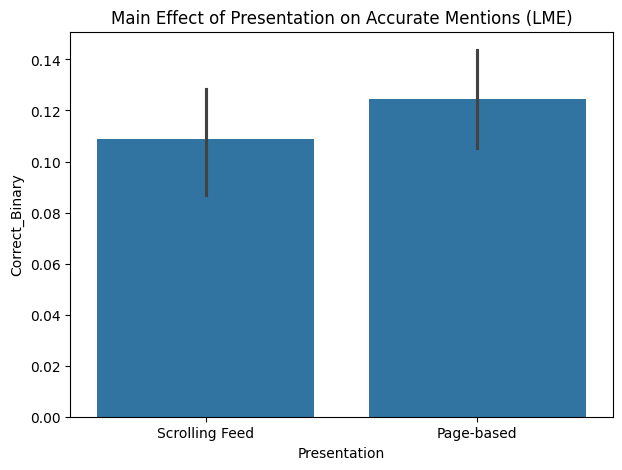

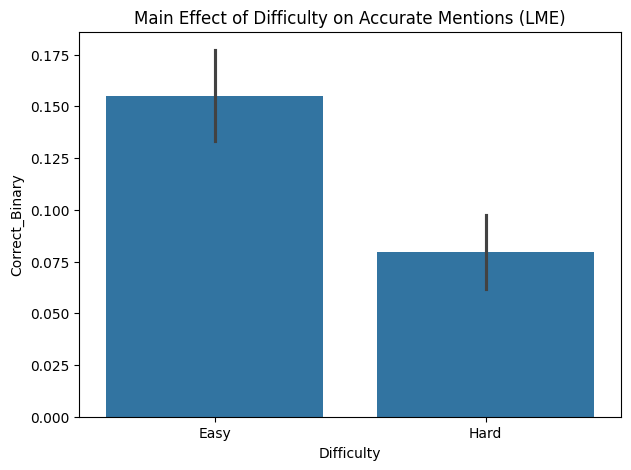

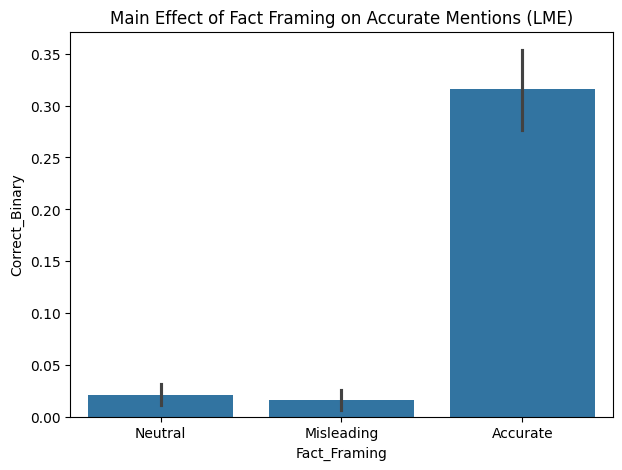

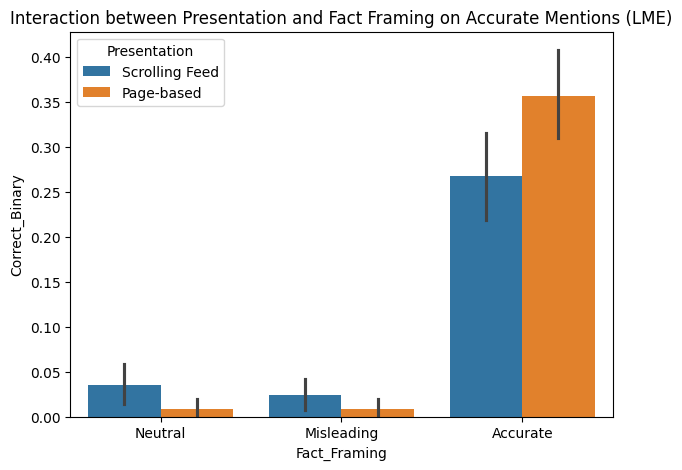

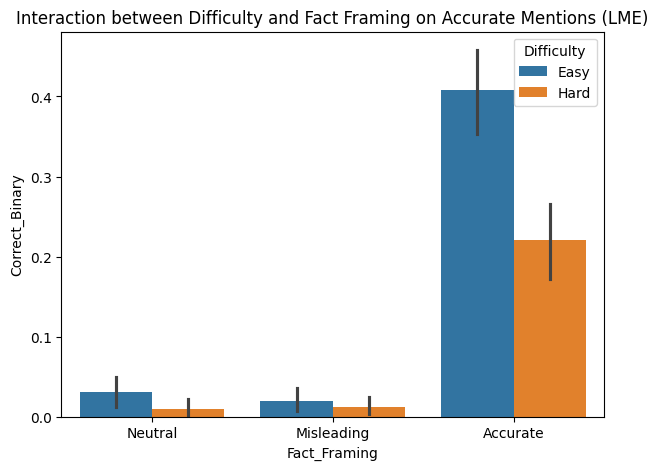

In [50]:
# Main effect of Presentation on Accurate Mentions
fig1 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Presentation', y='Correct_Binary')
plt.title('Main Effect of Presentation on Accurate Mentions (LME)')
save_plot(fig1, 'main_effect_presentation_accurate_mentions_lme.png')
plt.show()

# Main effect of Difficulty on Accurate Mentions
fig2 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Difficulty', y='Correct_Binary')
plt.title('Main Effect of Difficulty on Accurate Mentions (LME)')
save_plot(fig2, 'main_effect_difficulty_accurate_mentions_lme.png')
plt.show()

# Main effect of Fact Framing on Accurate Mentions
fig3 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Correct_Binary')
plt.title('Main Effect of Fact Framing on Accurate Mentions (LME)')
save_plot(fig3, 'main_effect_fact_framing_accurate_mentions_lme.png')
plt.show()

# Interaction between Presentation and Fact Framing on Accurate Mentions
fig4 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Correct_Binary', hue='Presentation')
plt.title('Interaction between Presentation and Fact Framing on Accurate Mentions (LME)')
save_plot(fig4, 'interaction_presentation_fact_framing_accurate_mentions_lme.png')
plt.show()

# Interaction between Difficulty and Fact Framing on Accurate Mentions
fig5 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Correct_Binary', hue='Difficulty')
plt.title('Interaction between Difficulty and Fact Framing on Accurate Mentions (LME)')
save_plot(fig5, 'interaction_difficulty_fact_framing_accurate_mentions_lme.png')
plt.show()


### Gist Recall (Partially Correct)

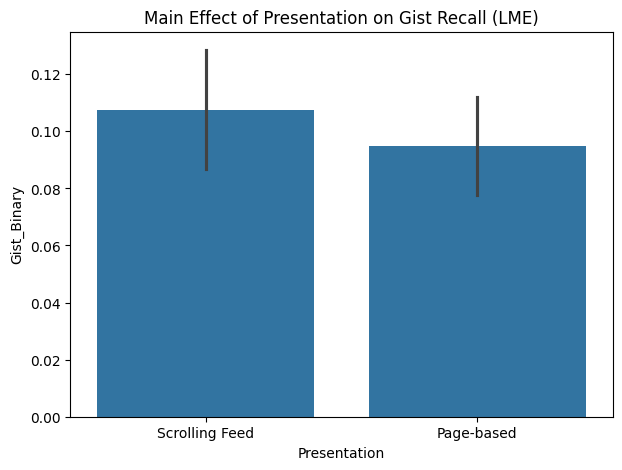

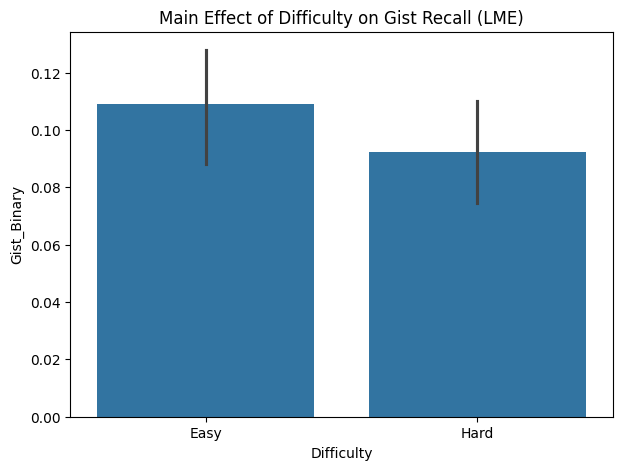

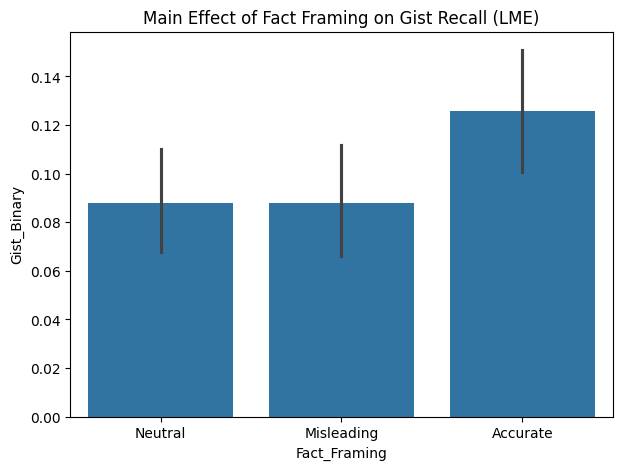

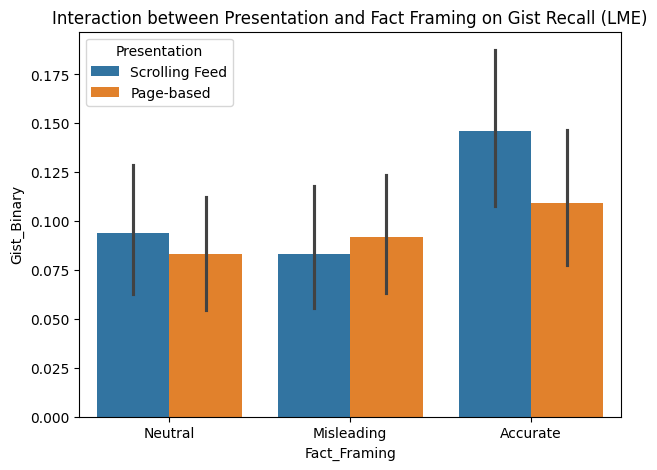

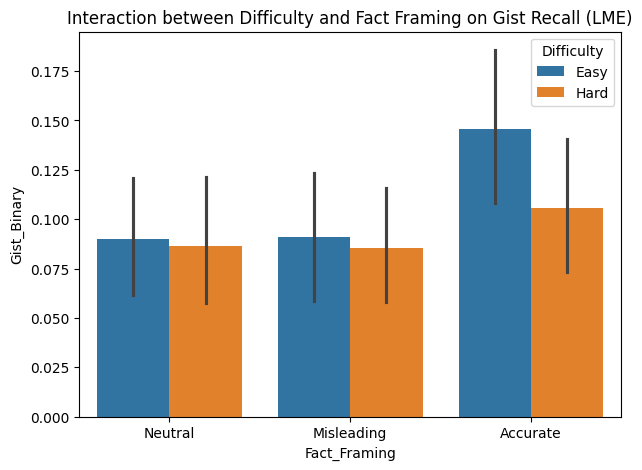

In [51]:
# Main effect of Presentation on Gist Recall
fig1 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Presentation', y='Gist_Binary')
plt.title('Main Effect of Presentation on Gist Recall (LME)')
save_plot(fig1, 'main_effect_presentation_gist_recall_lme.png')
plt.show()

# Main effect of Difficulty on Gist Recall
fig2 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Difficulty', y='Gist_Binary')
plt.title('Main Effect of Difficulty on Gist Recall (LME)')
save_plot(fig2, 'main_effect_difficulty_gist_recall_lme.png')
plt.show()

# Main effect of Fact Framing on Gist Recall
fig3 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Gist_Binary')
plt.title('Main Effect of Fact Framing on Gist Recall (LME)')
save_plot(fig3, 'main_effect_fact_framing_gist_recall_lme.png')
plt.show()

# Interaction between Presentation and Fact Framing on Gist Recall
fig4 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Gist_Binary', hue='Presentation')
plt.title('Interaction between Presentation and Fact Framing on Gist Recall (LME)')
save_plot(fig4, 'interaction_presentation_fact_framing_gist_recall_lme.png')
plt.show()

# Interaction between Difficulty and Fact Framing on Gist Recall
fig5 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Gist_Binary', hue='Difficulty')
plt.title('Interaction between Difficulty and Fact Framing on Gist Recall (LME)')
save_plot(fig5, 'interaction_difficulty_fact_framing_gist_recall_lme.png')
plt.show()


### Verbatim Recall (Correct)

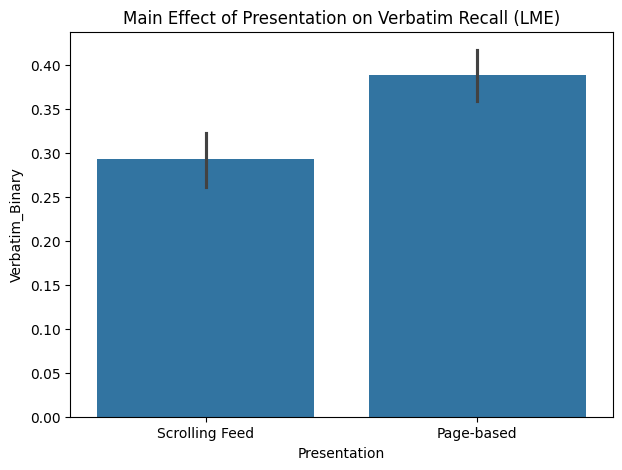

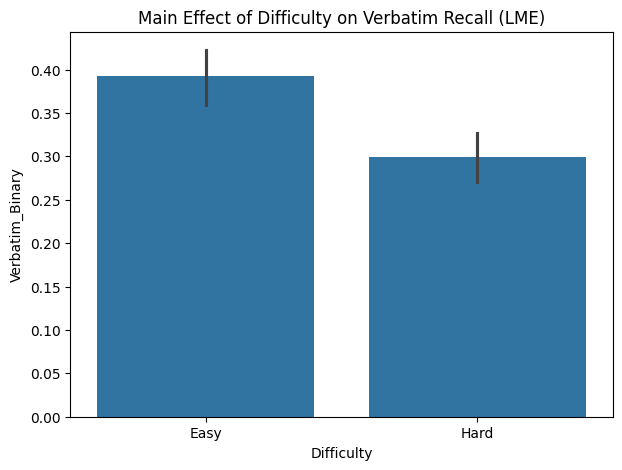

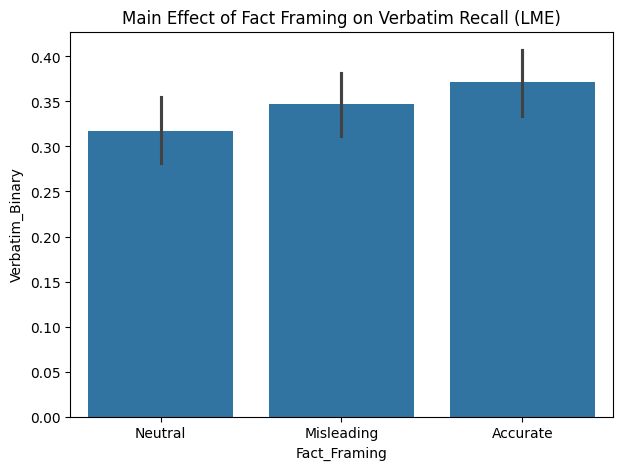

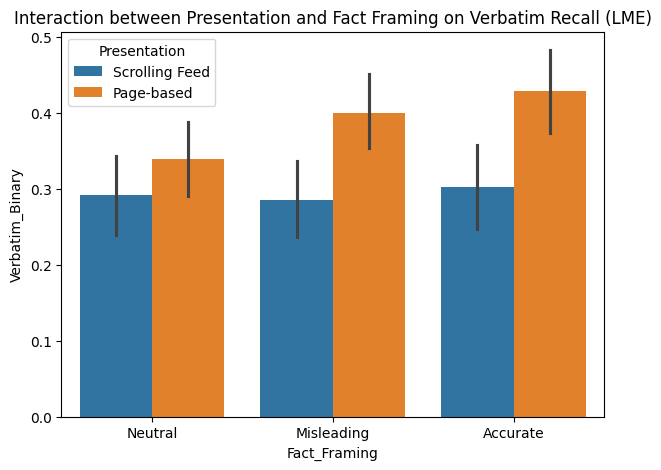

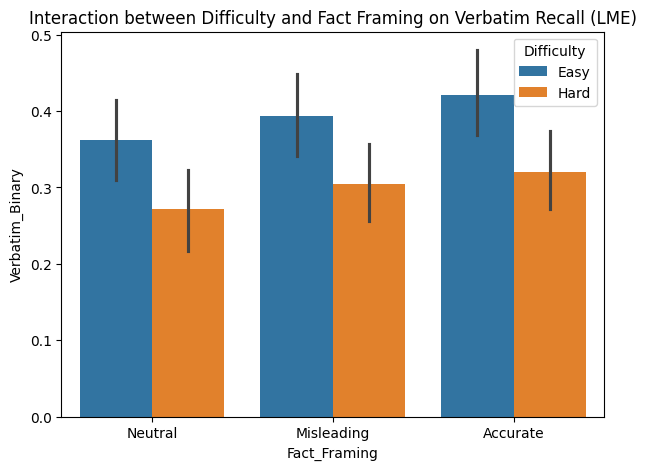

In [52]:
# Main effect of Presentation on Verbatim Recall
fig1 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Presentation', y='Verbatim_Binary')
plt.title('Main Effect of Presentation on Verbatim Recall (LME)')
save_plot(fig1, 'main_effect_presentation_verbatim_recall_lme.png')
plt.show()

# Main effect of Difficulty on Verbatim Recall
fig2 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Difficulty', y='Verbatim_Binary')
plt.title('Main Effect of Difficulty on Verbatim Recall (LME)')
save_plot(fig2, 'main_effect_difficulty_verbatim_recall_lme.png')
plt.show()

# Main effect of Fact Framing on Verbatim Recall
fig3 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Verbatim_Binary')
plt.title('Main Effect of Fact Framing on Verbatim Recall (LME)')
save_plot(fig3, 'main_effect_fact_framing_verbatim_recall_lme.png')
plt.show()

# Interaction between Presentation and Fact Framing on Verbatim Recall
fig4 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Verbatim_Binary', hue='Presentation')
plt.title('Interaction between Presentation and Fact Framing on Verbatim Recall (LME)')
save_plot(fig4, 'interaction_presentation_fact_framing_verbatim_recall_lme.png')
plt.show()

# Interaction between Difficulty and Fact Framing on Verbatim Recall
fig5 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Verbatim_Binary', hue='Difficulty')
plt.title('Interaction between Difficulty and Fact Framing on Verbatim Recall (LME)')
save_plot(fig5, 'interaction_difficulty_fact_framing_verbatim_recall_lme.png')
plt.show()


### Recall Intrusions

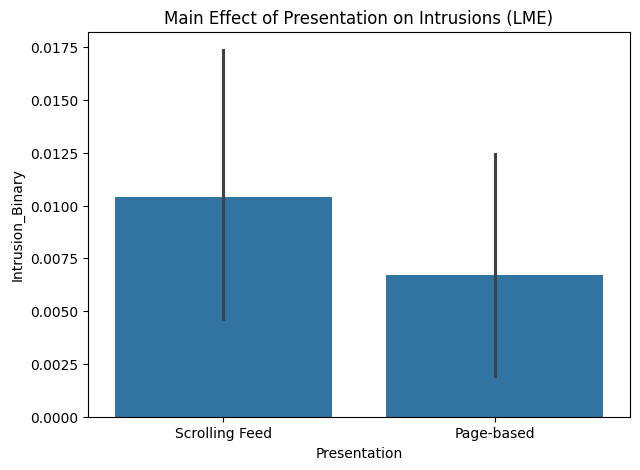

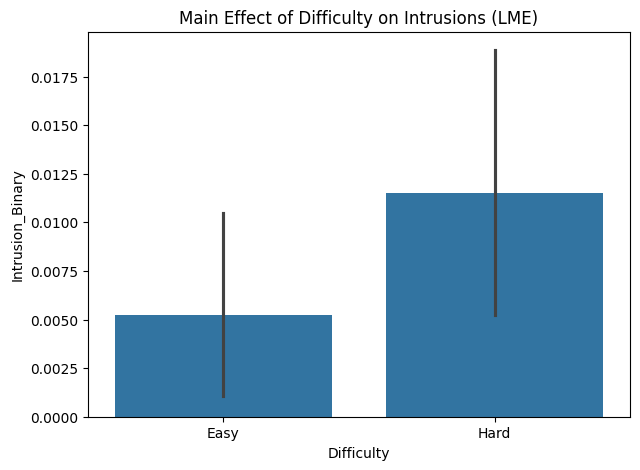

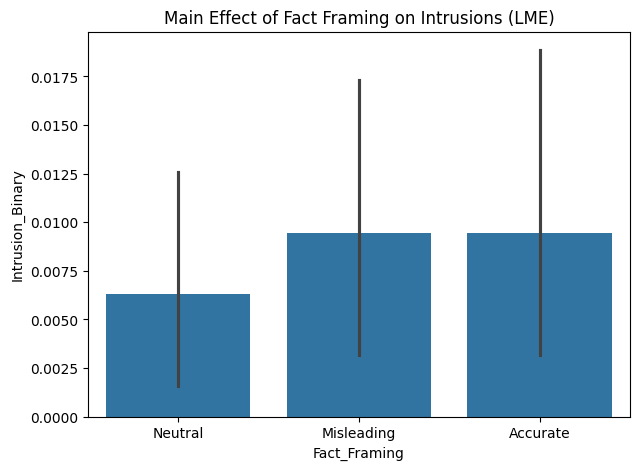

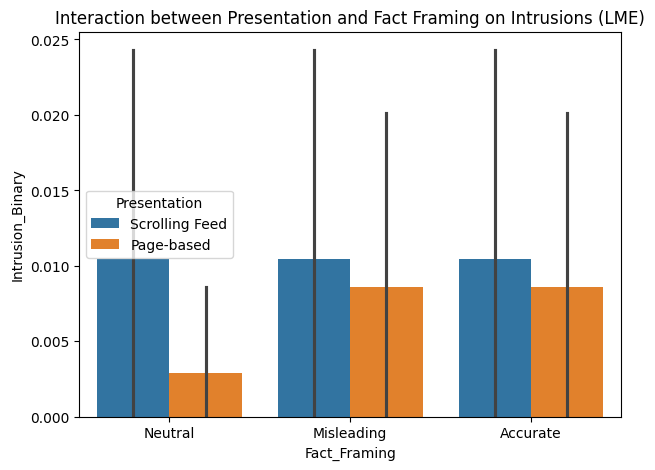

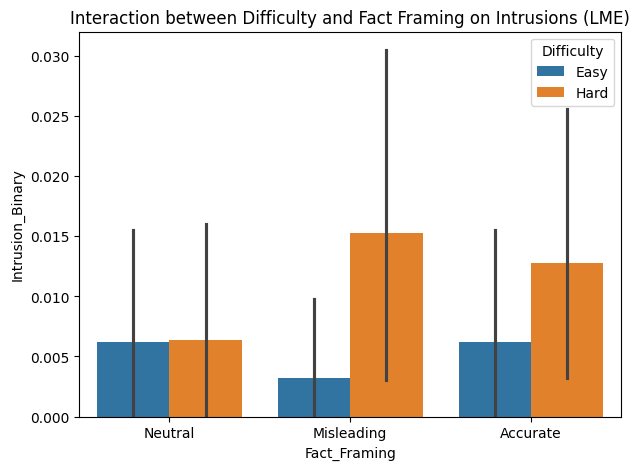

In [53]:
# Main effect of Presentation on Intrusions
fig1 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Presentation', y='Intrusion_Binary')
plt.title('Main Effect of Presentation on Intrusions (LME)')
save_plot(fig1, 'main_effect_presentation_intrusions_lme.png')
plt.show()

# Main effect of Difficulty on Intrusions
fig2 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Difficulty', y='Intrusion_Binary')
plt.title('Main Effect of Difficulty on Intrusions (LME)')
save_plot(fig2, 'main_effect_difficulty_intrusions_lme.png')
plt.show()

# Main effect of Fact Framing on Intrusions
fig3 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Intrusion_Binary')
plt.title('Main Effect of Fact Framing on Intrusions (LME)')
save_plot(fig3, 'main_effect_fact_framing_intrusions_lme.png')
plt.show()

# Interaction between Presentation and Fact Framing on Intrusions
fig4 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Intrusion_Binary', hue='Presentation')
plt.title('Interaction between Presentation and Fact Framing on Intrusions (LME)')
save_plot(fig4, 'interaction_presentation_fact_framing_intrusions_lme.png')
plt.show()

# Interaction between Difficulty and Fact Framing on Intrusions
fig5 = plt.figure(figsize=(7, 5))
sns.barplot(data=long_df, x='Fact_Framing', y='Intrusion_Binary', hue='Difficulty')
plt.title('Interaction between Difficulty and Fact Framing on Intrusions (LME)')
save_plot(fig5, 'interaction_difficulty_fact_framing_intrusions_lme.png')
plt.show()


### ANCOVA: Misleading Mentions

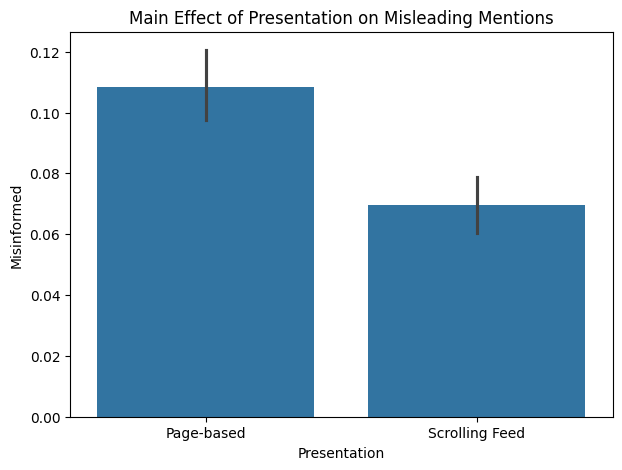

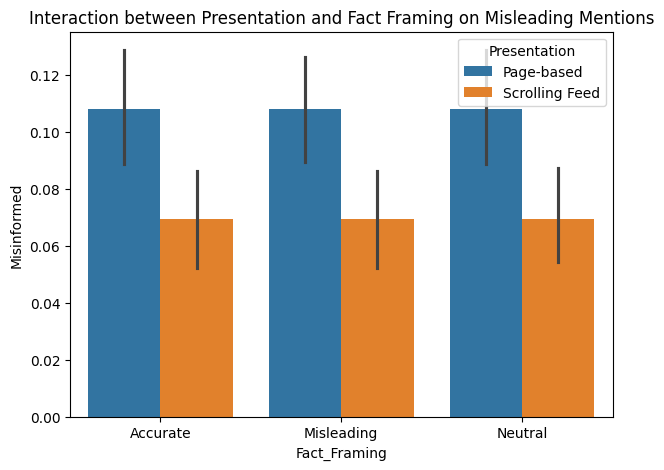

In [54]:
# Main effect of Presentation on Misleading Mentions
fig1 = plt.figure(figsize=(7, 5))
sns.barplot(data=proportions_df, x='Presentation', y='Misinformed')
plt.title('Main Effect of Presentation on Misleading Mentions')
save_plot(fig1, 'main_effect_presentation_misinformed_proportions.png')
plt.show()

# Interaction between Presentation and Fact Framing on Misleading Mentions
fig2 = plt.figure(figsize=(7, 5))
sns.barplot(data=proportions_df, x='Fact_Framing', y='Misinformed', hue='Presentation')
plt.title('Interaction between Presentation and Fact Framing on Misleading Mentions')
save_plot(fig2, 'interaction_presentation_fact_framing_misinformed_proportions.png')
plt.show()


### ANCOVA: Verbatim Correct

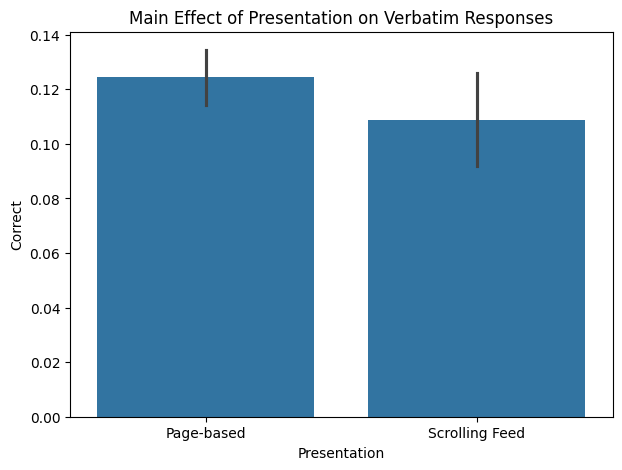

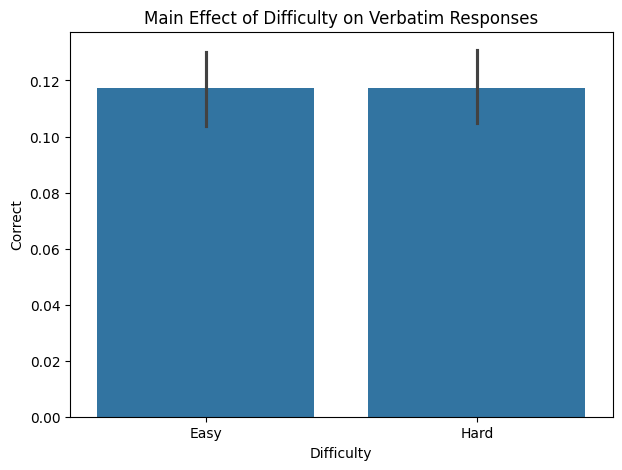

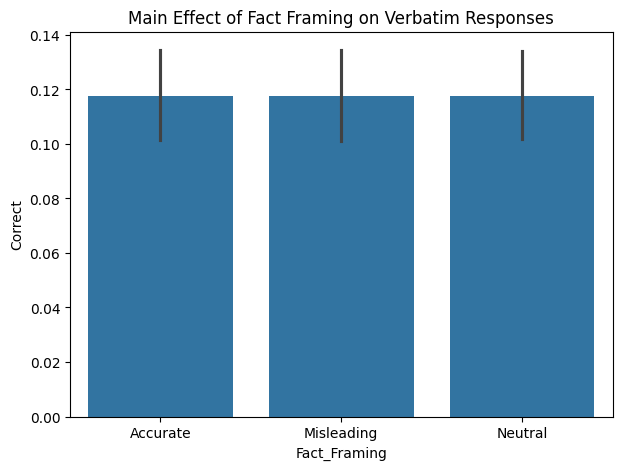

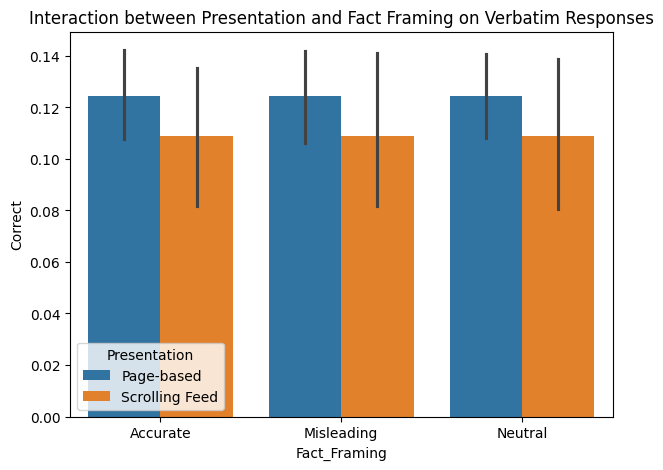

In [55]:
# Main effect of Presentation on Verbatim Responses
fig1 = plt.figure(figsize=(7, 5))
sns.barplot(data=proportions_df, x='Presentation', y='Correct')
plt.title('Main Effect of Presentation on Verbatim Responses')
save_plot(fig1, 'main_effect_presentation_verbatim_proportions.png')
plt.show()

# Main effect of Difficulty on Verbatim Responses
fig2 = plt.figure(figsize=(7, 5))
sns.barplot(data=proportions_df, x='Difficulty', y='Correct')
plt.title('Main Effect of Difficulty on Verbatim Responses')
save_plot(fig2, 'main_effect_difficulty_verbatim_proportions.png')
plt.show()

# Main effect of Fact Framing on Verbatim Responses
fig3 = plt.figure(figsize=(7, 5))
sns.barplot(data=proportions_df, x='Fact_Framing', y='Correct')
plt.title('Main Effect of Fact Framing on Verbatim Responses')
save_plot(fig3, 'main_effect_fact_framing_verbatim_proportions.png')
plt.show()

# Interaction between Presentation and Fact Framing on Verbatim Responses
fig4 = plt.figure(figsize=(7, 5))
sns.barplot(data=proportions_df, x='Fact_Framing', y='Correct', hue='Presentation')
plt.title('Interaction between Presentation and Fact Framing on Verbatim Responses')
save_plot(fig4, 'interaction_presentation_fact_framing_verbatim_proportions.png')
plt.show()


## Optional Follow Ups

### Bootstrapping

In [ ]:
from sklearn.utils import resample

def bootstrap(data, n_iterations, sample_size, func):
    statistics = []
    for i in range(n_iterations):
        sample = resample(data, n_samples=sample_size)
        statistic = func(sample)
        statistics.append(statistic)
    return np.percentile(statistics, [2.5, 97.5])

# Bootstrap 95% CI for mean Correct proportion
bootstrap_correct = bootstrap(proportions_df['Correct'], 1000, len(proportions_df), np.mean)
print("Bootstrap 95% CI for Correct Proportion:", bootstrap_correct)

# Bootstrap 95% CI for mean Misinformed proportion
bootstrap_misinformed = bootstrap(proportions_df['Misinformed'], 1000, len(proportions_df), np.mean)
print("Bootstrap 95% CI for Misinformed Proportion:", bootstrap_misinformed)


Robust Regression (ANCOVA)

In [ ]:
import statsmodels.formula.api as smf

# Huber regression for Correct Proportion
model_huber_correct = smf.rlm('Correct ~ Presentation * Difficulty * Fact_Framing + Duration_sec', data=proportions_df, M=sm.robust.norms.HuberT())
results_huber_correct = model_huber_correct.fit()
print("Huber Regression Results for Correct Proportion:")
print(results_huber_correct.summary())

# Huber regression for Misinformed Proportion
model_huber_misinformed = smf.rlm('Misinformed ~ Presentation * Difficulty * Fact_Framing + Duration_sec', data=proportions_df, M=sm.robust.norms.HuberT())
results_huber_misinformed = model_huber_misinformed.fit()
print("Huber Regression Results for Misinformed Proportion:")
print(results_huber_misinformed.summary())


###  Mixed Effects Model with Robust Standard Errors

In [ ]:
# Mixed Effects Model for Correct Responses
model_correct_robust = smf.mixedlm("Correct_Binary ~ Presentation * Difficulty * Fact_Framing + Duration_sec",
                                   long_df,
                                   groups=long_df["ID"],
                                   re_formula="~1")
result_correct_robust = model_correct_robust.fit(reml=True)
# Manually compute robust standard errors
robust_cov_correct = result_correct_robust.cov_params() * result_correct_robust.scale
robust_se_correct = np.sqrt(np.diag(robust_cov_correct))

print("Mixed Effects Model with Robust Standard Errors for Correct Responses:")
print(result_correct_robust.summary())
print("\nRobust Standard Errors:")
print(robust_se_correct)

# Mixed Effects Model for Misinformed Responses
model_misinformed_robust = smf.mixedlm("Misinformed_Binary ~ Presentation * Difficulty * Fact_Framing + Duration_sec",
                                       long_df,
                                       groups=long_df["ID"],
                                       re_formula="~1")
result_misinformed_robust = model_misinformed_robust.fit(reml=True)
# Manually compute robust standard errors
robust_cov_misinformed = result_misinformed_robust.cov_params() * result_misinformed_robust.scale
robust_se_misinformed = np.sqrt(np.diag(robust_cov_misinformed))

print("Mixed Effects Model with Robust Standard Errors for Misinformed Responses:")
print(result_misinformed_robust.summary())
print("\nRobust Standard Errors:")
print(robust_se_misinformed)


# Readme

# Experiment 1A General Knowledge Analysis

This repository contains the script and instructions to preprocess, analyze, and visualize data for Experiment 1A, which investigates the impact of presentation format, difficulty, and fact framing on general knowledge recall. The analysis includes mixed effects models, ANCOVA, effect size calculations, and various plots to support the findings.

## Prerequisites

- Python 3.7 or higher
- Required Python libraries:
  - gspread
  - google-auth
  - google-auth-oauthlib
  - google-auth-httplib2
  - pandas
  - numpy
  - seaborn
  - matplotlib
  - statsmodels

## Setup

1. Clone the repository and navigate to the project directory.

2. Install the required Python libraries using pip:

    ```bash
    pip install gspread google-auth google-auth-oauthlib google-auth-httplib2 pandas numpy seaborn matplotlib statsmodels
    ```

3. Upload your `credentials.json` file to authenticate access to Google Sheets.

## Data Preprocessing

1. Load data from the specified Google Sheet.
2. Convert relevant columns to appropriate types and map categorical variables.
3. Convert data to long format and create binary response columns for `Correct_Binary` and `Misinformed_Binary`.

## Descriptive Statistics and Diagnostic Plots

1. Calculate and print descriptive statistics.
2. Generate diagnostic plots for assumption checks (normality, homoscedasticity, etc.).

## Mixed Effects Models

1. Fit mixed effects models for correct and misinformed responses.
2. Manually compute robust standard errors.

## ANCOVA Analyses

1. Perform ANCOVA on proportion data for correct and misinformed responses.
2. Conduct post-hoc analyses for significant results.

## Effect Size Calculations

1. Calculate Hedge's g for significant comparisons in both the mixed effects and ANCOVA results.
2. Calculate effect sizes for raw count data.

## Plotting Analysis Results

1. Generate and save plots for the main effects and interactions for both correct and misinformed responses (based on proportions and raw counts).

## Script Overview

The script is organized into the following sections:

1. **Setup and Data Loading:** Installs necessary libraries and loads data from Google Sheets.
2. **Data Preprocessing:** Converts data to long format and creates necessary columns.
3. **Descriptive Statistics:** Calculates and prints descriptive statistics, generates diagnostic plots.
4. **Mixed Effects Models with Robust Standard Errors:** Fits mixed effects models and computes robust standard errors.
5. **ANCOVA Analyses:** Performs ANCOVA on proportion data and conducts post-hoc analyses.
6. **Effect Size Calculations:** Calculates Hedge's g for significant comparisons.
7. **Plotting Analysis Results:** Generates and saves plots for main effects and interactions.

## Running the Script

1. Ensure you have the `credentials.json` file in your working dir
